# Library

In [1]:
# My library
from molgraph.dataset import *
from molgraph.testingconsensus import *
from molgraph.visualize import *
from molgraph.interpret import *
from molgraph.experiment import *
# General library
import numpy as np
import pandas as pd
import scipy as sp
import os
# pytorch
import torch
from matplotlib.pyplot import figure

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set_theme(style="white", palette=None)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

/opt/anaconda3/envs/moleculegraph38/lib/python3.8/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


# Argument

In [2]:
parser = ArgumentParser()
args = parser.getArgument('''
--file bbbp
--model GIN
--schema AR_0
--reduced functional
--mol_embedding 256
--batch_normalize
--fold 5
'''.split())

args

Namespace(batch_normalize=True, batch_size=256, class_number=1, device=device(type='cpu'), dropout=0.4, edge_dim=32, experiment_number='001', file='bbbp', fold=5, gpu=-1, grad_norm=1.0, graphtask='classification', heads=1, hidden_channels=256, in_channels=256, lr=5e-05, lr_schedule=True, model='GIN', mol_embedding=256, num_epochs=300, num_layers=3, num_layers_reduced=3, num_layers_self=3, num_layers_self_reduced=3, out_channels=256, patience=30, reduced=['functional'], schema='AR_0', seed=42, smiles='smiles', splitting='scaffold', splitting_seed=42, task='p_np', vocab_len=100, weight_decay=5e-05)

# Dataset

In [3]:
file = args.file
smiles = args.smiles 
task = args.task
splitting = args.splitting 
splitting_fold = args.fold
splitting_seed = args.splitting_seed

# get validated dataset
datasets = getDataset(file, smiles, task, splitting)
# compute positive weight for classification
if args.graphtask == 'classification':
    args.pos_weight = getPosWeight(datasets)
    print('pos_weight:', args.pos_weight)
# generate dataset splitting
datasets_splitted = generateDatasetSplitting(file, splitting, splitting_fold, splitting_seed)
# generate all graph dataset
datasets_graph = generateGraphDataset(file)
# generate all reduced graph dataset
dict_reducedgraph = dict()
for g in args.reduced:
    if g == 'substructure':
        for i in range(splitting_fold):
            vocab_file = file+'_'+str(i)
            if not os.path.exists('vocab/'+vocab_file+'.txt'):
                generateVocabTrain(file, splitting_seed, splitting_fold, vocab_len=args.vocab_len)
            dict_reducedgraph[g] = generateReducedGraphDict(file, g, vocab_file=vocab_file)
    else:
        dict_reducedgraph[g] = generateReducedGraphDict(file, g)

Function: getDataset()
number of valid smiles: 2019
pos_weight: 0.3025806451612903
Function: generateDatasetSplitting()
Fold: 5
Fold Number: 0
-- Datasets Train: 1292
-- Datasets Val: 323
-- Datasets Test:  404
-- Total: 2019
Fold Number: 1
-- Datasets Train: 1292
-- Datasets Val: 323
-- Datasets Test:  404
-- Total: 2019
Fold Number: 2
-- Datasets Train: 1292
-- Datasets Val: 323
-- Datasets Test:  404
-- Total: 2019
Fold Number: 3
-- Datasets Train: 1292
-- Datasets Val: 323
-- Datasets Test:  404
-- Total: 2019
Fold Number: 4
-- Datasets Train: 1292
-- Datasets Val: 323
-- Datasets Test:  404
-- Total: 2019
Function: generateGraphDataset()
Datasets graph:  1965


# Test

In [19]:
import os
args_test = dict()

# Load model
ts = "2023-Apr-09-15:17:09"
args_test = dict()
reduced_list = '_'.join(args.reduced)
# directory = './dataset/'+os.path.join(*[args.file, args.model+'_'+args.schema+'_'+reduced_list])
# ts = next(os.walk(directory))[1][0]
reduced_list = '_'.join(args.reduced)
args_test['log_folder_name'] = os.path.join(*[args.file, args.model+'_'+args.schema+'_'+reduced_list, f"{ts}"])
args_test['exp_name'] = args.experiment_number
# args_test['fold_number'] = fold_number
args_test['seed'] = args.seed

training_bin = torch.load('./dataset/'+args_test['log_folder_name']+'/checkpoints/training_args.bin')

args.batch_size = training_bin.batch_size
args.num_layers = training_bin.num_layers
args.num_layers_reduced = training_bin.num_layers_reduced
args.in_channels = training_bin.in_channels
args.hidden_channels = training_bin.hidden_channels
args.out_channels = training_bin.out_channels
args.edge_dim = training_bin.edge_dim
args.num_layers_self = training_bin.num_layers_self
args.num_layers_self_reduced = training_bin.num_layers_self_reduced
args.dropout = training_bin.dropout
args.lr = training_bin.lr
args.weight_decay = training_bin.weight_decay
# print(args)
testing_smiles = ''

# # test with single sample
# testing_type = 'sample'
# testing_smiles = 'CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](N)Cc1ccc(O)cc1)C(=O)N[C@@H](CCCCN)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](C)C(=O)N1CCC[C@H]1C(=O)NCC(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](C)C(=O)N[C@@H](CO)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](C)C(=O)N[C@@H](CO)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1cnc[nH]1)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CC(C)C)C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H](CCCNC(=N)N)C(=O)N1CCC[C@H]1C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](Cc1ccc(O)cc1)C(N)=O)[C@@H](C)O)C(C)C'
# smiles_processes = mol_to_smiles(smiles_to_mol(testing_smiles, with_atom_index=False))
# molecule_test = constructGraph(smiles_processes, 1)
# datasets_test = {testing_smiles: molecule_test}

# # test dataset original
# testing_type = 'test_dataset'
# test_loader, datasets_test =  generateDataLoaderTesting(args.file, args.batch_size)

# # test dataset external
# testing_type = 'external'
# test_external = 'test_external.csv'
# datasets_test_df = pd.read_csv('dataset/'+args.file+'/'+test_external)
# datasets_test_list = []
# for idx, row in datasets_test_df.iterrows():
#     smiles_processes = mol_to_smiles(smiles_to_mol(row['X'], with_atom_index=False))
#     d = constructGraph(smiles_processes, row['y'])
#     datasets_test_list.append(d)
# test_loader, datasets_test =  generateDataLoaderListing(datasets_test_list, 1)
# datasets_test = {d.smiles: d for d in datasets_test}

# all dataset
testing_type = 'dataset'
datasets_test = datasets_graph


all_dataset = datasets_test

# Running

In [20]:
print('Number of dataset:', len(all_dataset))

Number of dataset: 1965


In [21]:
if testing_type == 'sample' or testing_type == 'external' or testing_type == 'test_dataset':
    prediction_fold_df = getPredictionFold(args, args_test, all_dataset, datasets_splitted=None)
    prediction_consensus_df = getPredictionConsensus(prediction_fold_df)
    
elif testing_type == 'dataset':
    reduced_list = '_'.join(args.reduced)
    directory = args.model+'_'+args.schema+'_'+reduced_list
    path_fold = 'dataset/'+file+'/prediction_fold_'+args.file+'_'+directory+'.csv'
    path_consensus = 'dataset/'+file+'/prediction_consensus_'+args.file+'_'+directory+'.csv'
    prediction_fold_df = pd.DataFrame()
    prediction_consensus_df = pd.DataFrame()

    if os.path.exists(path_fold):
        prediction_fold_df = pd.read_csv(path_fold)
    else:
        prediction_fold_df = getPredictionFold(args, args_test, all_dataset, datasets_splitted=datasets_splitted)
        prediction_fold_df.to_csv(path_fold, index=False)

    if os.path.exists(path_consensus):
        prediction_consensus_df = pd.read_csv(path_consensus)
    else:
        prediction_consensus_df = getPredictionConsensus(prediction_fold_df)
        prediction_consensus_df.to_csv(path_consensus, index=False)

print('prediction_fold_df', len(prediction_fold_df))
print('prediction_consensus_df', len(prediction_consensus_df))

getMaskGraph:   5%|▌         | 100/1965 [00:23<06:17,  4.94it/s][14:30:25] WARNING: not removing hydrogen atom without neighbors
[14:30:25] WARNING: not removing hydrogen atom without neighbors
[14:30:25] WARNING: not removing hydrogen atom without neighbors
[14:30:25] WARNING: not removing hydrogen atom without neighbors
[14:30:25] WARNING: not removing hydrogen atom without neighbors
[14:30:25] WARNING: not removing hydrogen atom without neighbors
[14:30:25] WARNING: not removing hydrogen atom without neighbors
[14:30:25] WARNING: not removing hydrogen atom without neighbors
[14:30:25] WARNING: not removing hydrogen atom without neighbors
[14:30:25] WARNING: not removing hydrogen atom without neighbors
[14:30:25] WARNING: not removing hydrogen atom without neighbors
[14:30:25] WARNING: not removing hydrogen atom without neighbors
[14:30:25] WARNING: not removing hydrogen atom without neighbors
getMaskGraph:   6%|▌         | 114/1965 [00:26<07:18,  4.22it/s][14:30:28] WARNING: not rem

prediction_fold_df 593050
prediction_consensus_df 118610


In [22]:
prediction_consensus_df.head()

Fold SMILES_original                  SMILES  Split  Prediction  TrueValue  \
0    C       BrC(Br)Br  Br[CH:1]([Br:2])[Br:3]  train    0.961439        1.0   
1    C       BrC(Br)Br  Br[CH:1]([Br:2])[Br:3]  train    0.961439        1.0   
2    C       BrC(Br)Br  Br[CH:1]([Br:2])[Br:3]  train    0.961439        1.0   
3    C       BrC(Br)Br  Br[CH:1]([Br:2])[Br:3]  train    0.961439        1.0   
4    C       BrC(Br)Br  Br[CH:1]([Br:2])[Br:3]  train    0.961439        1.0   

       Schema  Node_ID Node_Feature    Weight  Weight_Other  
0        atom        0       [a] Br  0.800000           NaN  
1        atom        1        [a] C  0.200000           NaN  
2        atom        2       [a] Br  0.800000           NaN  
3        atom        3       [a] Br  0.800000           NaN  
4  functional        0       [f] -X  0.266667           NaN

Prediction Result (class): {0.945570317715468}
Prediction Result (class): True
graph_g {'atom': {0: 0.2500787370175944, 1: 0.042126810216086885, 2: 0.1908969020554203, 3: 0.24340620778042507, 4: 0.33044799732339464, 5: 1.0, 6: 0.6814628166023285, 7: 0.645564589037967, 8: 0.645564589037967, 9: 0.0}, 'bond': {}}


[15:14:22] The new font size 1 is below the current minimum (6).
[15:14:22] The new font size 1 is below the current minimum (6).


graph_r {'atom': {0: 0.0, 1: 0.0, 2: 0.5986131827958158, 3: 0.5323402266863292, 4: 0.26248523634427345, 5: 1.0}, 'bond': {}}


[15:14:24] The new font size 1 is below the current minimum (6).
[15:14:24] The new font size 1 is below the current minimum (6).


graph_x {'atom': {0: 0.24063035211405784, 1: 0.9347402793664387, 2: 0.505189925444118, 3: 0.4931910087756142, 4: 0.9999999999999999, 5: 0.4242310595763413, 6: 0.0, 7: 0.028031492701099947, 8: 0.028031492701099947, 9: 0.44060836764935984}, 'bond': {}}


{'prediction': 0.945570317715468,
 'graph_g': {'atom': {0: 0.2500787370175944,
   1: 0.042126810216086885,
   2: 0.1908969020554203,
   3: 0.24340620778042507,
   4: 0.33044799732339464,
   5: 1.0,
   6: 0.6814628166023285,
   7: 0.645564589037967,
   8: 0.645564589037967,
   9: 0.0},
  'bond': {}},
 'graph_r': {'atom': {0: 0.0,
   1: 0.0,
   2: 0.5986131827958158,
   3: 0.5323402266863292,
   4: 0.26248523634427345,
   5: 1.0},
  'bond': {}},
 'graph_x': {'atom': {0: 0.24063035211405784,
   1: 0.9347402793664387,
   2: 0.505189925444118,
   3: 0.4931910087756142,
   4: 0.9999999999999999,
   5: 0.4242310595763413,
   6: 0.0,
   7: 0.028031492701099947,
   8: 0.028031492701099947,
   9: 0.44060836764935984},
  'bond': {}}}

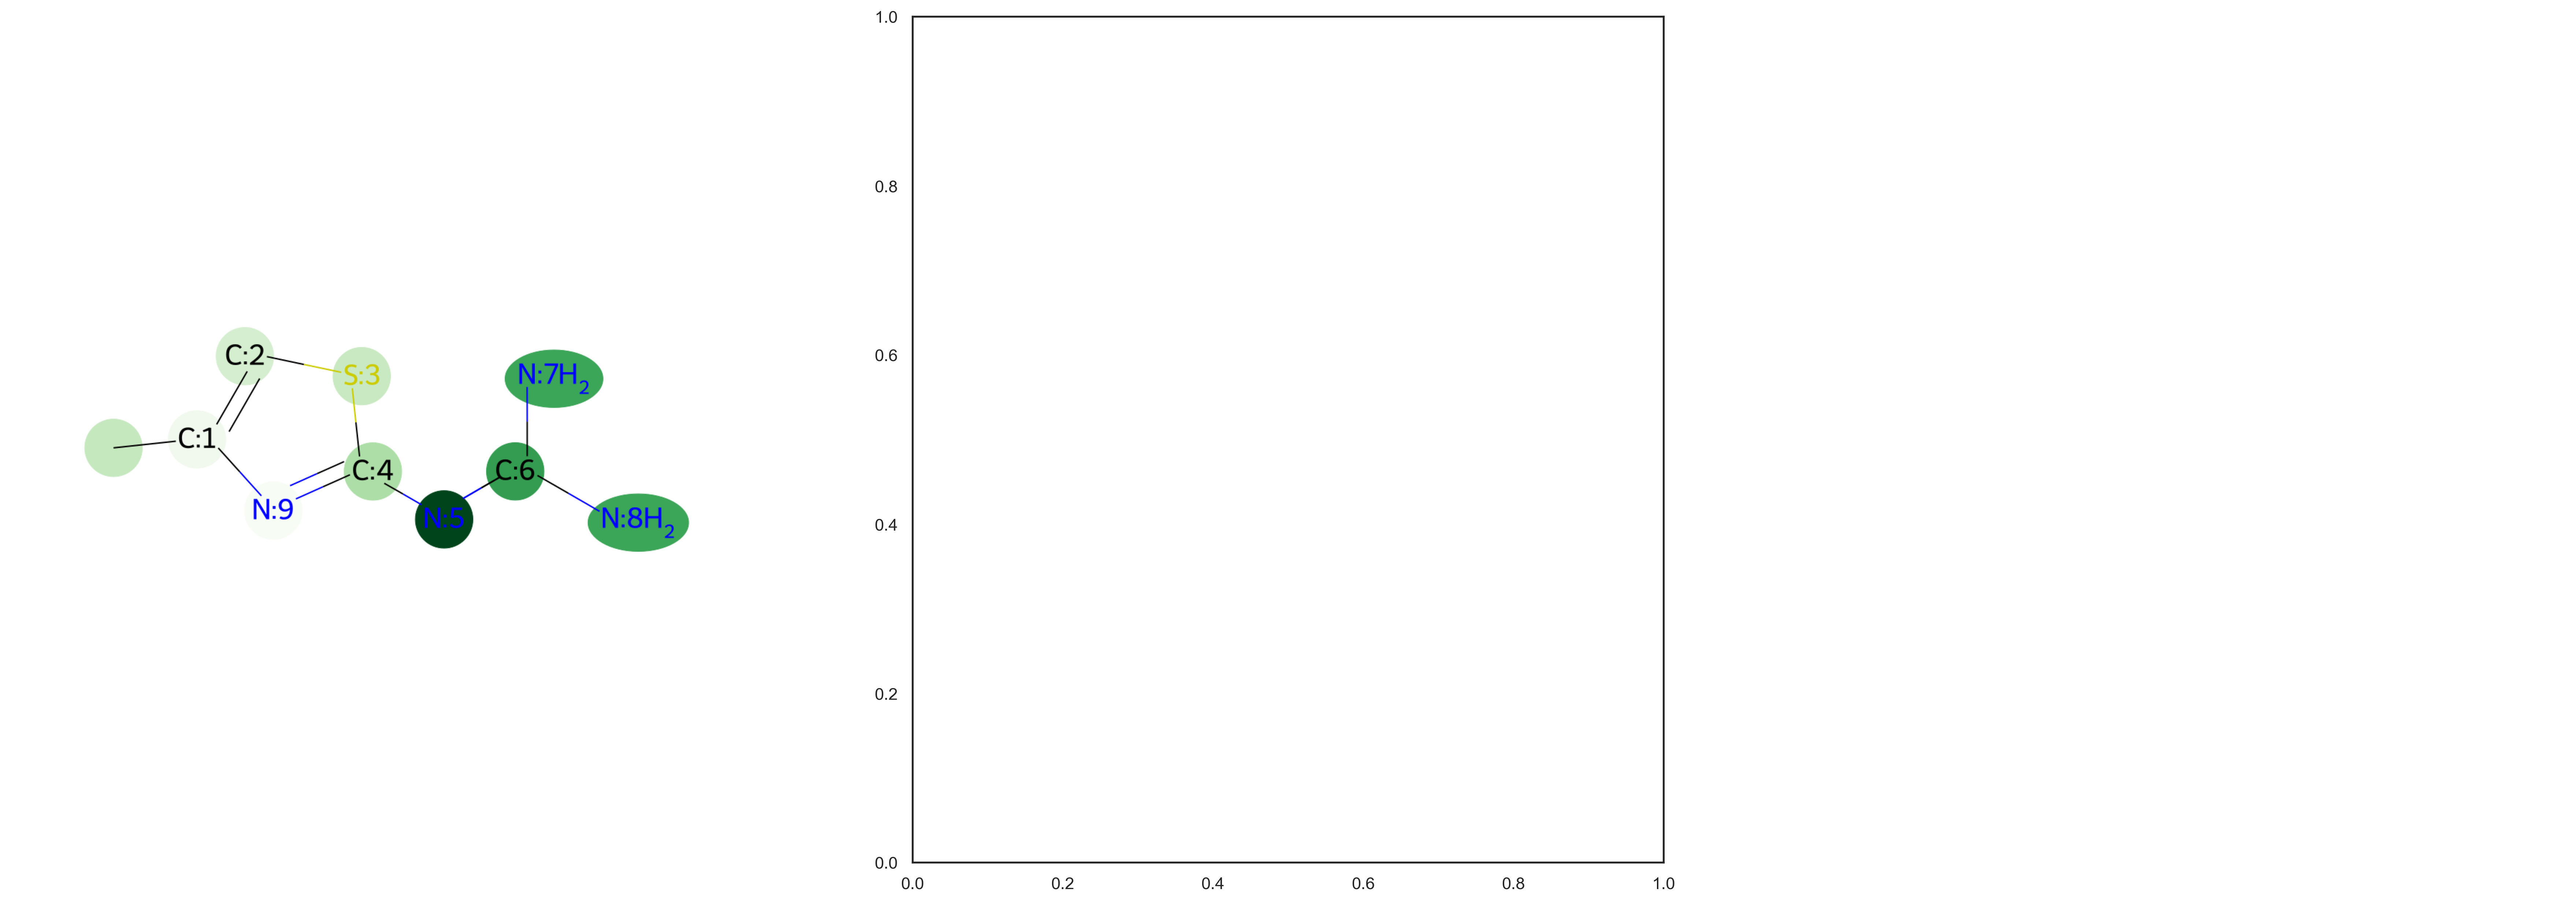

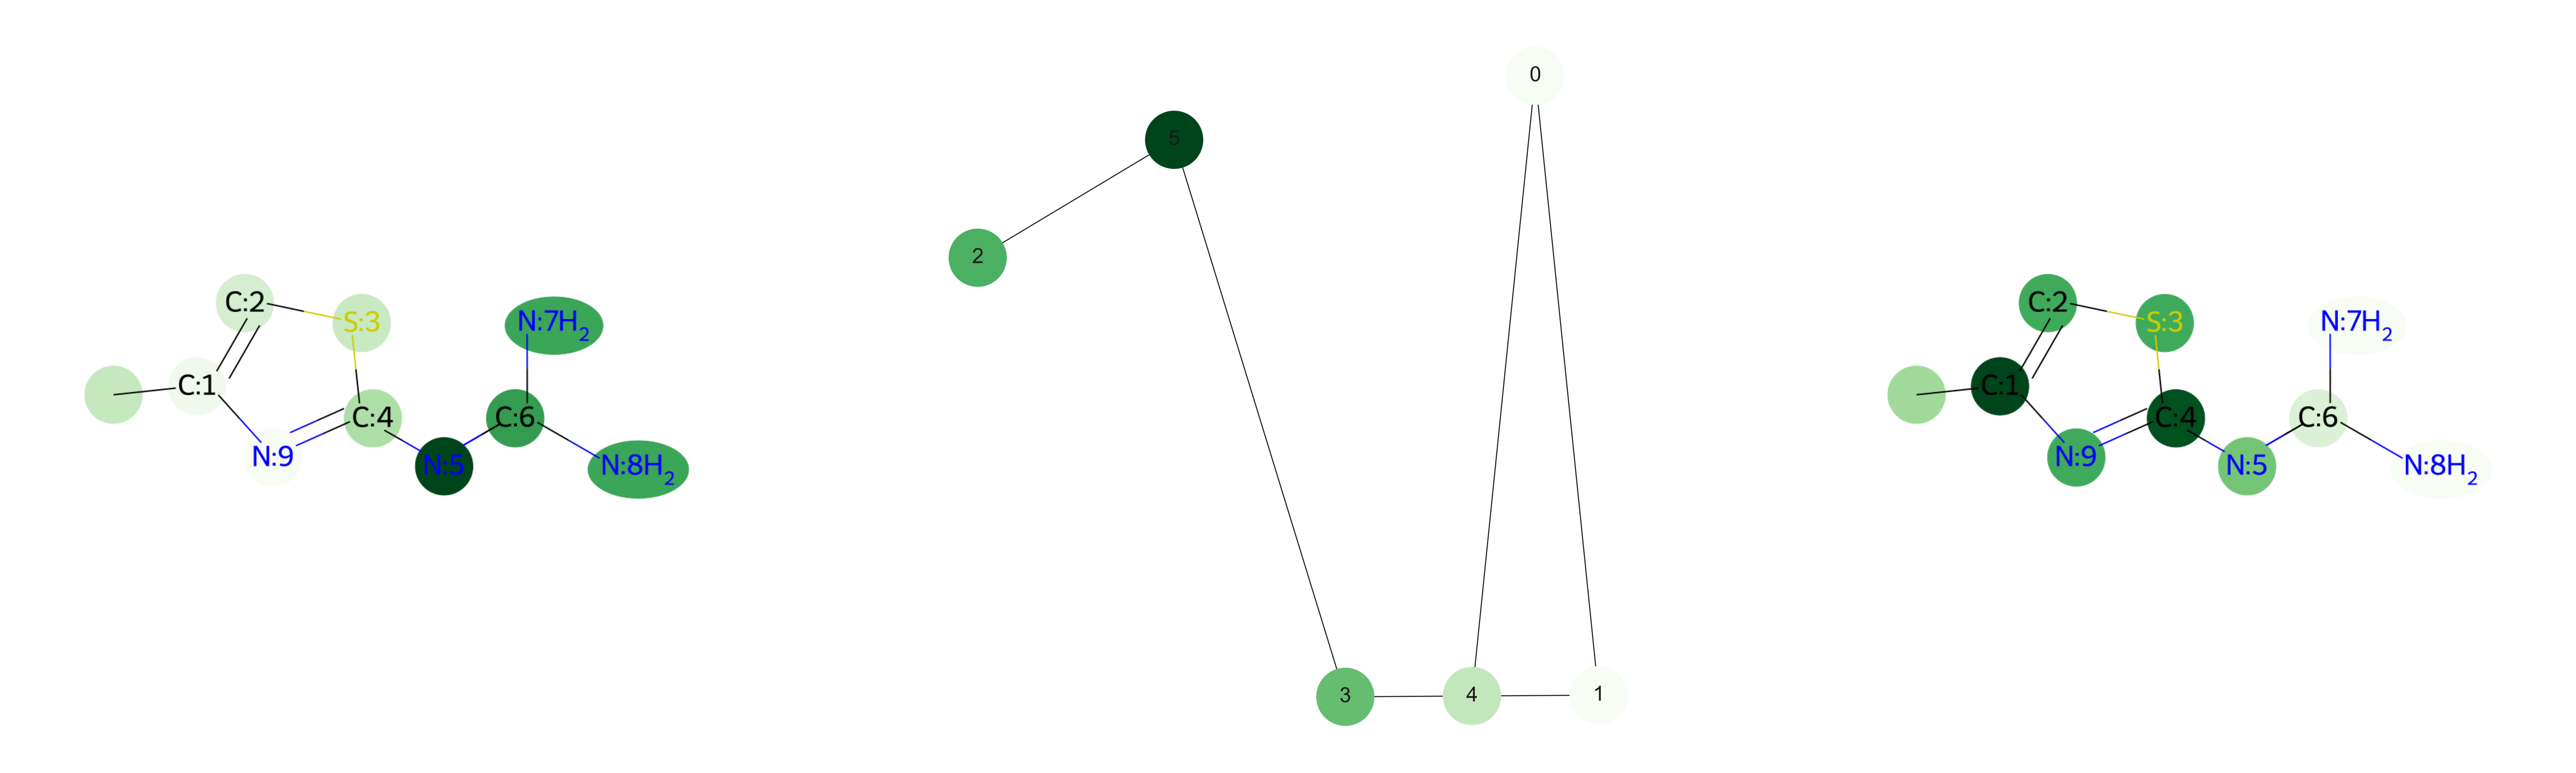

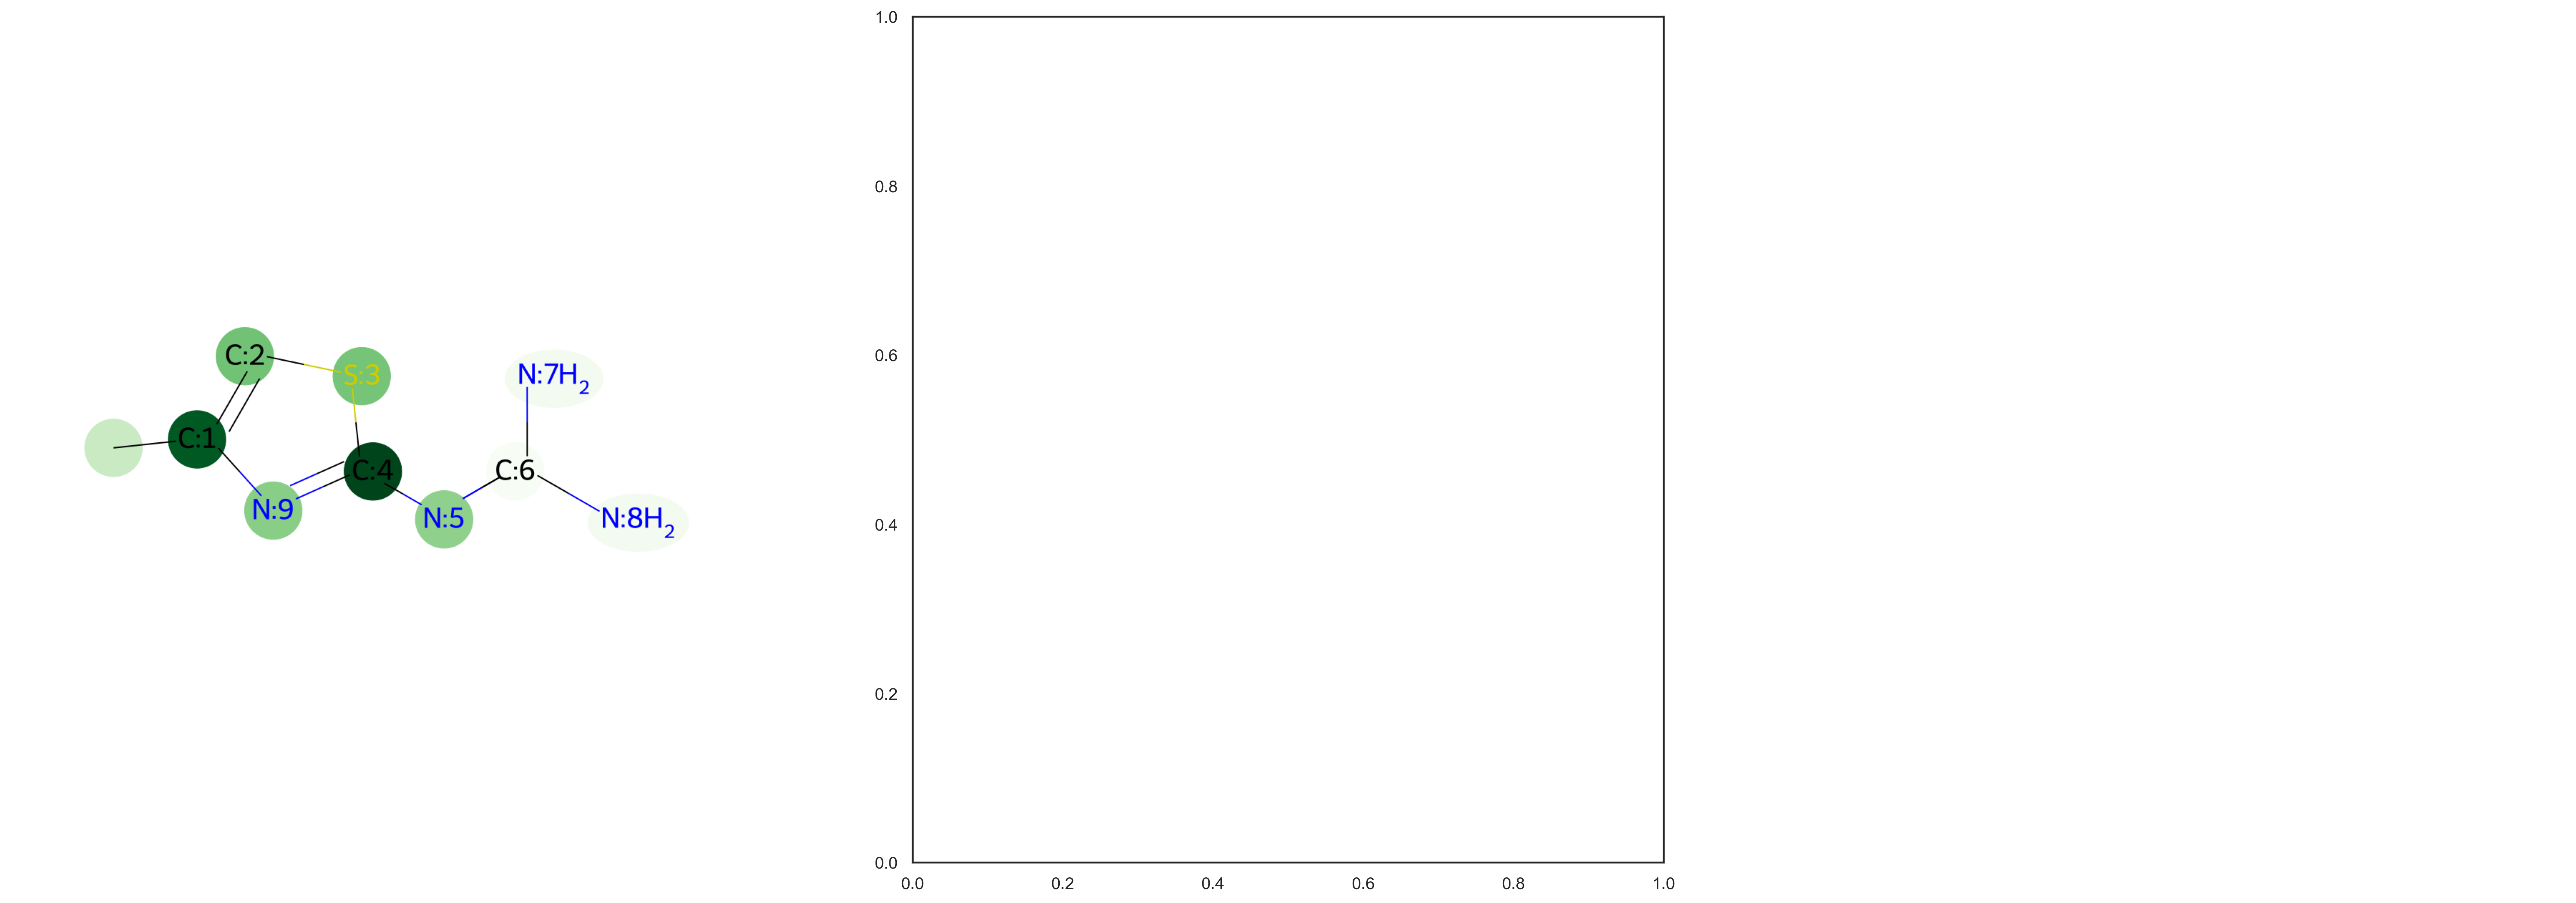

In [23]:
if testing_type == 'sample':
    smiles_test = Chem.MolToSmiles(Chem.MolFromSmiles(testing_smiles))
else:
    smiles_test = Chem.MolToSmiles(Chem.MolFromSmiles(list(all_dataset.keys())[0]))
    
prediction_mol_df = prediction_consensus_df[prediction_consensus_df['SMILES_original'] == smiles_test]
prediction_mol_df
getPrediction(prediction_mol_df, args, print_result=True)

## Performance

In [24]:
if args.graphtask == 'classification' and len(prediction_consensus_df) > 1:
    prediction_consensus_df_unique = prediction_consensus_df.drop_duplicates(subset=['SMILES_original'])
    print(accuracy_score(prediction_consensus_df_unique['TrueValue'], [i>=0.5 for i in prediction_consensus_df_unique['Prediction']]))

0.9460559796437659


## Prediction Distribution

In [25]:
prediction_consensus_df.head()

Fold SMILES_original                  SMILES  Split  Prediction  TrueValue  \
0    C       BrC(Br)Br  Br[CH:1]([Br:2])[Br:3]  train    0.961439        1.0   
1    C       BrC(Br)Br  Br[CH:1]([Br:2])[Br:3]  train    0.961439        1.0   
2    C       BrC(Br)Br  Br[CH:1]([Br:2])[Br:3]  train    0.961439        1.0   
3    C       BrC(Br)Br  Br[CH:1]([Br:2])[Br:3]  train    0.961439        1.0   
4    C       BrC(Br)Br  Br[CH:1]([Br:2])[Br:3]  train    0.961439        1.0   

       Schema  Node_ID Node_Feature    Weight  Weight_Other  
0        atom        0       [a] Br  0.800000           NaN  
1        atom        1        [a] C  0.200000           NaN  
2        atom        2       [a] Br  0.800000           NaN  
3        atom        3       [a] Br  0.800000           NaN  
4  functional        0       [f] -X  0.266667           NaN

1965


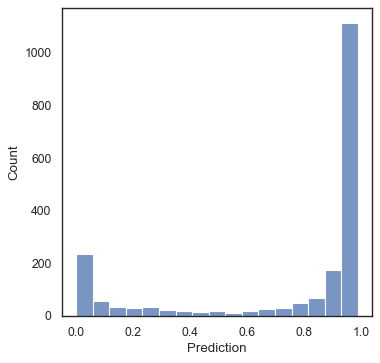

In [26]:
from matplotlib.pyplot import figure
figure(figsize=(5, 5), dpi=80)
prediction_consensus_df_unique = prediction_consensus_df.drop_duplicates(subset=['SMILES_original'])
fig = sns.histplot(prediction_consensus_df_unique['Prediction'])
print(len(prediction_consensus_df_unique['Prediction']))

## Attention Distribution

118610


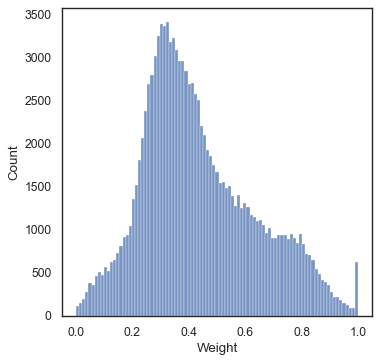

In [27]:
from matplotlib.pyplot import figure
figure(figsize=(5, 5), dpi=80)
fig = sns.histplot(prediction_consensus_df['Weight'])
print(len(prediction_consensus_df['Weight']))

## Feature Node Occurance

Node_Feature  Node_Feature_nodes_series  \
0    [a] ('C', 'In Aromatic', 'In Ring')                      14395   
1                   [a] ('C', 'In Ring')                      11404   
2                                  [a] C                       9663   
3                                [f] C-C                       6504   
4                                  [a] O                       5512   
..                                   ...                        ...   
105                     [f] c1cSnn1_atom                          1   
106                           [f] -N=CH2                          1   
107                [f] ('-C(=O)O', '-O')                          1   
108                               [a] Ca                          1   
109                 [a] ('B', 'In Ring')                          1   

     Node_Feature_smiles_series  
0                          1553  
1                          1441  
2                          1866  
3                          1745  
4                          1646  
..                          ...  
105                           1  
106                           1  
107                           1  
108                           1  
109                           1  

[110 rows x 3 columns]

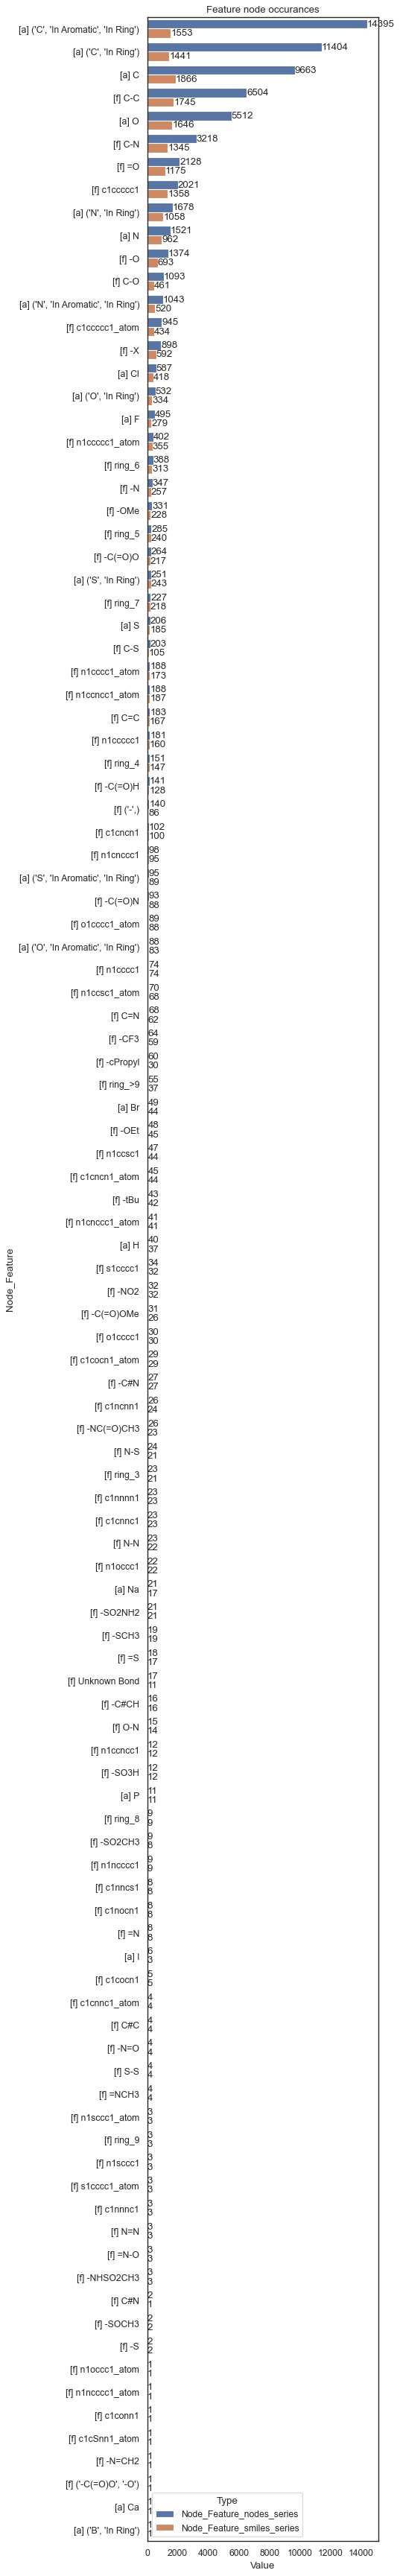

In [28]:
pred_ar_df = prediction_consensus_df[prediction_consensus_df['Schema']!='x'].copy()[['SMILES', 'Node_Feature']]

def countOccurance(pred_df):
    # all nodes
    feature_occ_nodes_series = pred_df['Node_Feature'].value_counts()
    # unique smiles
    pred_ar_df_unique = pred_df.drop_duplicates(subset=['SMILES', 'Node_Feature'])
    feature_occ_smiles_series = pred_ar_df_unique['Node_Feature'].value_counts()
    # concat
    feature_occ_df = pd.DataFrame(feature_occ_nodes_series)
    feature_occ_df = feature_occ_df.merge(feature_occ_smiles_series, how='outer', left_index=True, right_index=True, suffixes=('_nodes_series', '_smiles_series'))
    feature_occ_df = feature_occ_df.sort_values(by=['Node_Feature_nodes_series'], ascending=False)
    feature_occ_df = feature_occ_df.reset_index().rename(columns={'index':'Node_Feature'})
    return feature_occ_df

feature_occ_df = countOccurance(pred_ar_df)
display(feature_occ_df)

# plot
feature_occ_df_melt = pd.melt(feature_occ_df, id_vars='Node_Feature', value_vars=['Node_Feature_nodes_series', 'Node_Feature_smiles_series'], var_name='Type', value_name='Value')
figure(figsize=(5, len(feature_occ_df_melt)//4), dpi=80)
fig = sns.barplot(data=feature_occ_df_melt, x='Value', y='Node_Feature', hue='Type')
fig.set_title('Feature node occurances')

for i in fig.containers:
    fig.bar_label(i,)

In [29]:
feature_mt_10 = feature_occ_df[(feature_occ_df['Node_Feature_nodes_series']>=10) & (feature_occ_df['Node_Feature_smiles_series']>=10)]['Node_Feature'].tolist()
# feature_mt_10

## Average Weights

78

Node_Feature    Weight  Node_Feature_nodes_series  \
0       [f] -C(=O)O  0.927280                        264   
1       [f] c1cncn1  0.816579                        102   
2    [f] -NC(=O)CH3  0.791636                         26   
3  [f] n1cccc1_atom  0.777515                        188   
4       [f] s1cccc1  0.761983                         34   

   Node_Feature_smiles_series  
0                         217  
1                         100  
2                          23  
3                         173  
4                          32

70891

Fold                                    SMILES_original  \
22560     C  CC1(C)S[C@@H]2[C@H](NC(=O)C34C[C@@H]5C[C@@H](C...   
69389     C  CO/N=C(\C(=O)NC1C(=O)N(OCC(=O)O)[C@H]1C)c1csc(...   
102293    C  Nc1nc(=O)c2c([nH]1)NCC(CNc1ccc(C(=O)N[C@@H](CC...   
102292    C  Nc1nc(=O)c2c([nH]1)NCC(CNc1ccc(C(=O)N[C@@H](CC...   
46594     C  CCOc1ccc2ccccc2c1C(=O)N[C@@H]1C(=O)N2[C@@H]1SC...   

                                                   SMILES  Split  Prediction  \
22560   C[C:1]1([CH3:2])[S:3][C@@H:4]2[C@H:5]([NH:6][C...   test    0.062181   
69389   C[O:1]/[N:2]=[C:3](\[C:4](=[O:5])[NH:6][CH:7]1...  train    0.023970   
102293  N[c:1]1[n:2][c:3](=[O:4])[c:5]2[c:6]([nH:7]1)[...   test    0.134985   
102292  N[c:1]1[n:2][c:3](=[O:4])[c:5]2[c:6]([nH:7]1)[...   test    0.134985   
46594   C[CH2:1][O:2][c:3]1[cH:4][cH:5][c:6]2[cH:7][cH...  train    0.020966   

        TrueValue      Schema  Node_ID Node_Feature    Weight  Weight_Other  \
22560         0.0  functional        0  [f] -C(=O)O  1.000000           NaN   
69389         0.0  functional        0  [f] -C(=O)O  1.000000           NaN   
102293        1.0  functional        1  [f] -C(=O)O  0.681477           NaN   
102292        1.0  functional        0  [f] -C(=O)O  1.000000           NaN   
46594         0.0  functional        0  [f] -C(=O)O  1.000000           NaN   

                 Bin  
22560   (2e-05, 0.1]  
69389   (2e-05, 0.1]  
102293    (0.1, 0.2]  
102292    (0.1, 0.2]  
46594   (2e-05, 0.1]

/var/folders/fl/g9sn9nh944x6hrlyr03lfy080000gp/T/ipykernel_83336/2284089711.py:42: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(sm, ax=ax)


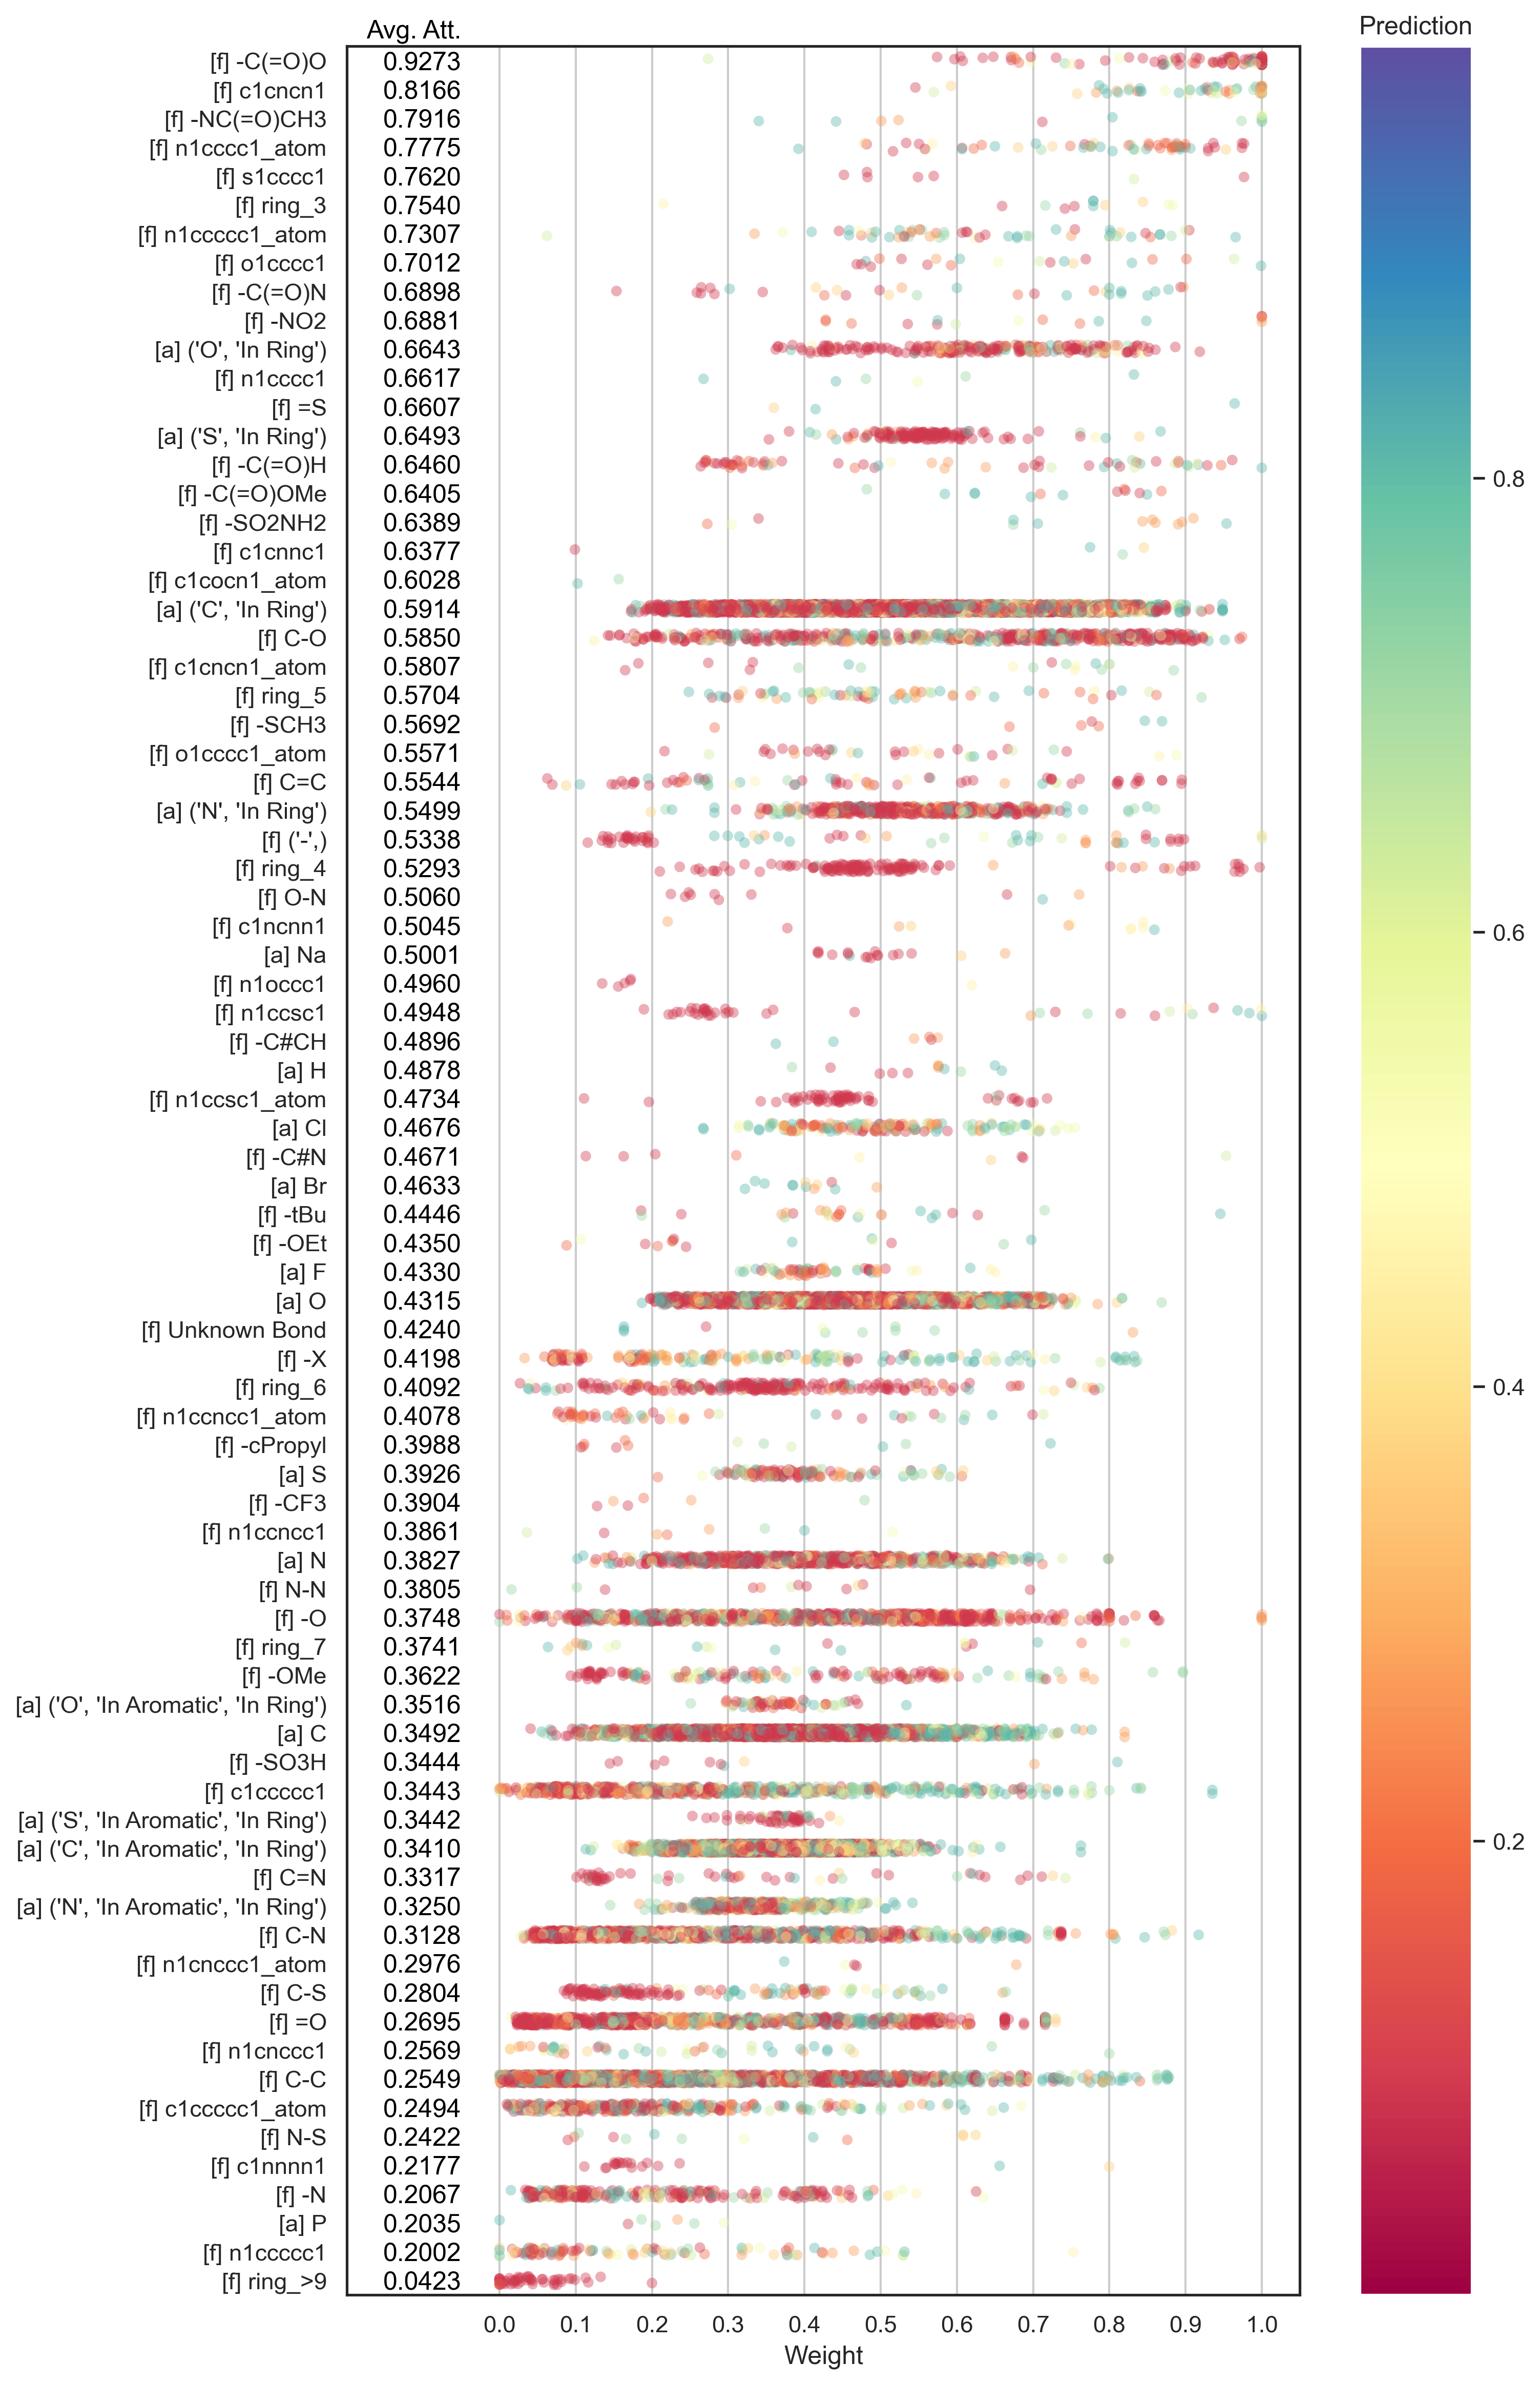

In [30]:
from matplotlib.cm import ScalarMappable
if args.graphtask == 'regression' or args.graphtask == 'classification':
    
    pred_ar_df = prediction_consensus_df[prediction_consensus_df['Schema']!='x'].copy()
    # filter by list
    pred_ar_df = pred_ar_df[pred_ar_df['Node_Feature'].isin(feature_mt_10)]

    avg_att_df = pred_ar_df.groupby(['Node_Feature'])['Weight'].mean().reset_index().sort_values(by=['Weight'], ascending=False).reset_index(drop=True)
    avg_att_df = avg_att_df.merge(feature_occ_df, how='left', on='Node_Feature')
    display(len(avg_att_df), avg_att_df.head())
    labels = list(avg_att_df['Node_Feature'])
    pred_ar_df = pred_ar_df.sort_values(by='Node_Feature', key=lambda x: x.map({v: i for i, v in enumerate(avg_att_df['Node_Feature'])}))

    bin = np.arange(min(pred_ar_df['Prediction']), max(pred_ar_df['Prediction']), step=0.1)
    pred_ar_df['Bin'] = pd.cut(pred_ar_df['Prediction'], bin, precision=1)
    display(len(pred_ar_df), pred_ar_df.head())

    fig, axes = plt.subplots(1, 1, figsize=(10, len(labels)//4))
    sns.set(font_scale=1)

    # plt.figure()
    cpal = sns.color_palette('Spectral',n_colors=len(bin),desat=1.)
    ax = sns.stripplot(x='Weight', y='Node_Feature', data=pred_ar_df, 
                       jitter=0.15, edgecolor='none', alpha=0.4, size=5, hue='Bin', palette=cpal)
    ax.text(x=-0.05, y=-0.8, s="Avg. Att.", 
                horizontalalignment='right', size='medium', color='black')
    for idx, row in avg_att_df.iterrows():
        ax.text(x=-0.05, y=idx+0.3, s="{:.4f}".format(row['Weight']), 
                horizontalalignment='right', size='medium', color='black')
    ax.yaxis.grid(False)
    ax.xaxis.grid(True)
    ax.set(ylabel=None)
    ax.set_xlim(-0.2, 1.05)
    plt.xticks(list(np.arange(0, 1.1, 0.1)))
    # sns.despine()

    # This is the part about the colormap
    cmap = plt.get_cmap("Spectral")
    norm = plt.Normalize(pred_ar_df['Prediction'].min(), pred_ar_df['Prediction'].max())
    sm =  ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.ax.set_title("Prediction")

    #remove the legend created by seaborn
    ax.legend_.remove()

    plt.show()

202

Node_Feature  Prediction_Class  Weight_Mean  Weight_Std  \
0     [f] -NHSO2CH3              True     0.974238    0.036433   
1       [f] -C(=O)O             False     0.957054    0.095760   
2  [f] n1occc1_atom              True     0.900750         NaN   
3       [f] c1cncn1             False     0.899491    0.130097   
4           [f] S-S             False     0.871182         NaN   

  Node_Feature_Type  
0               [f]  
1               [f]  
2               [f]  
3               [f]  
4               [f]

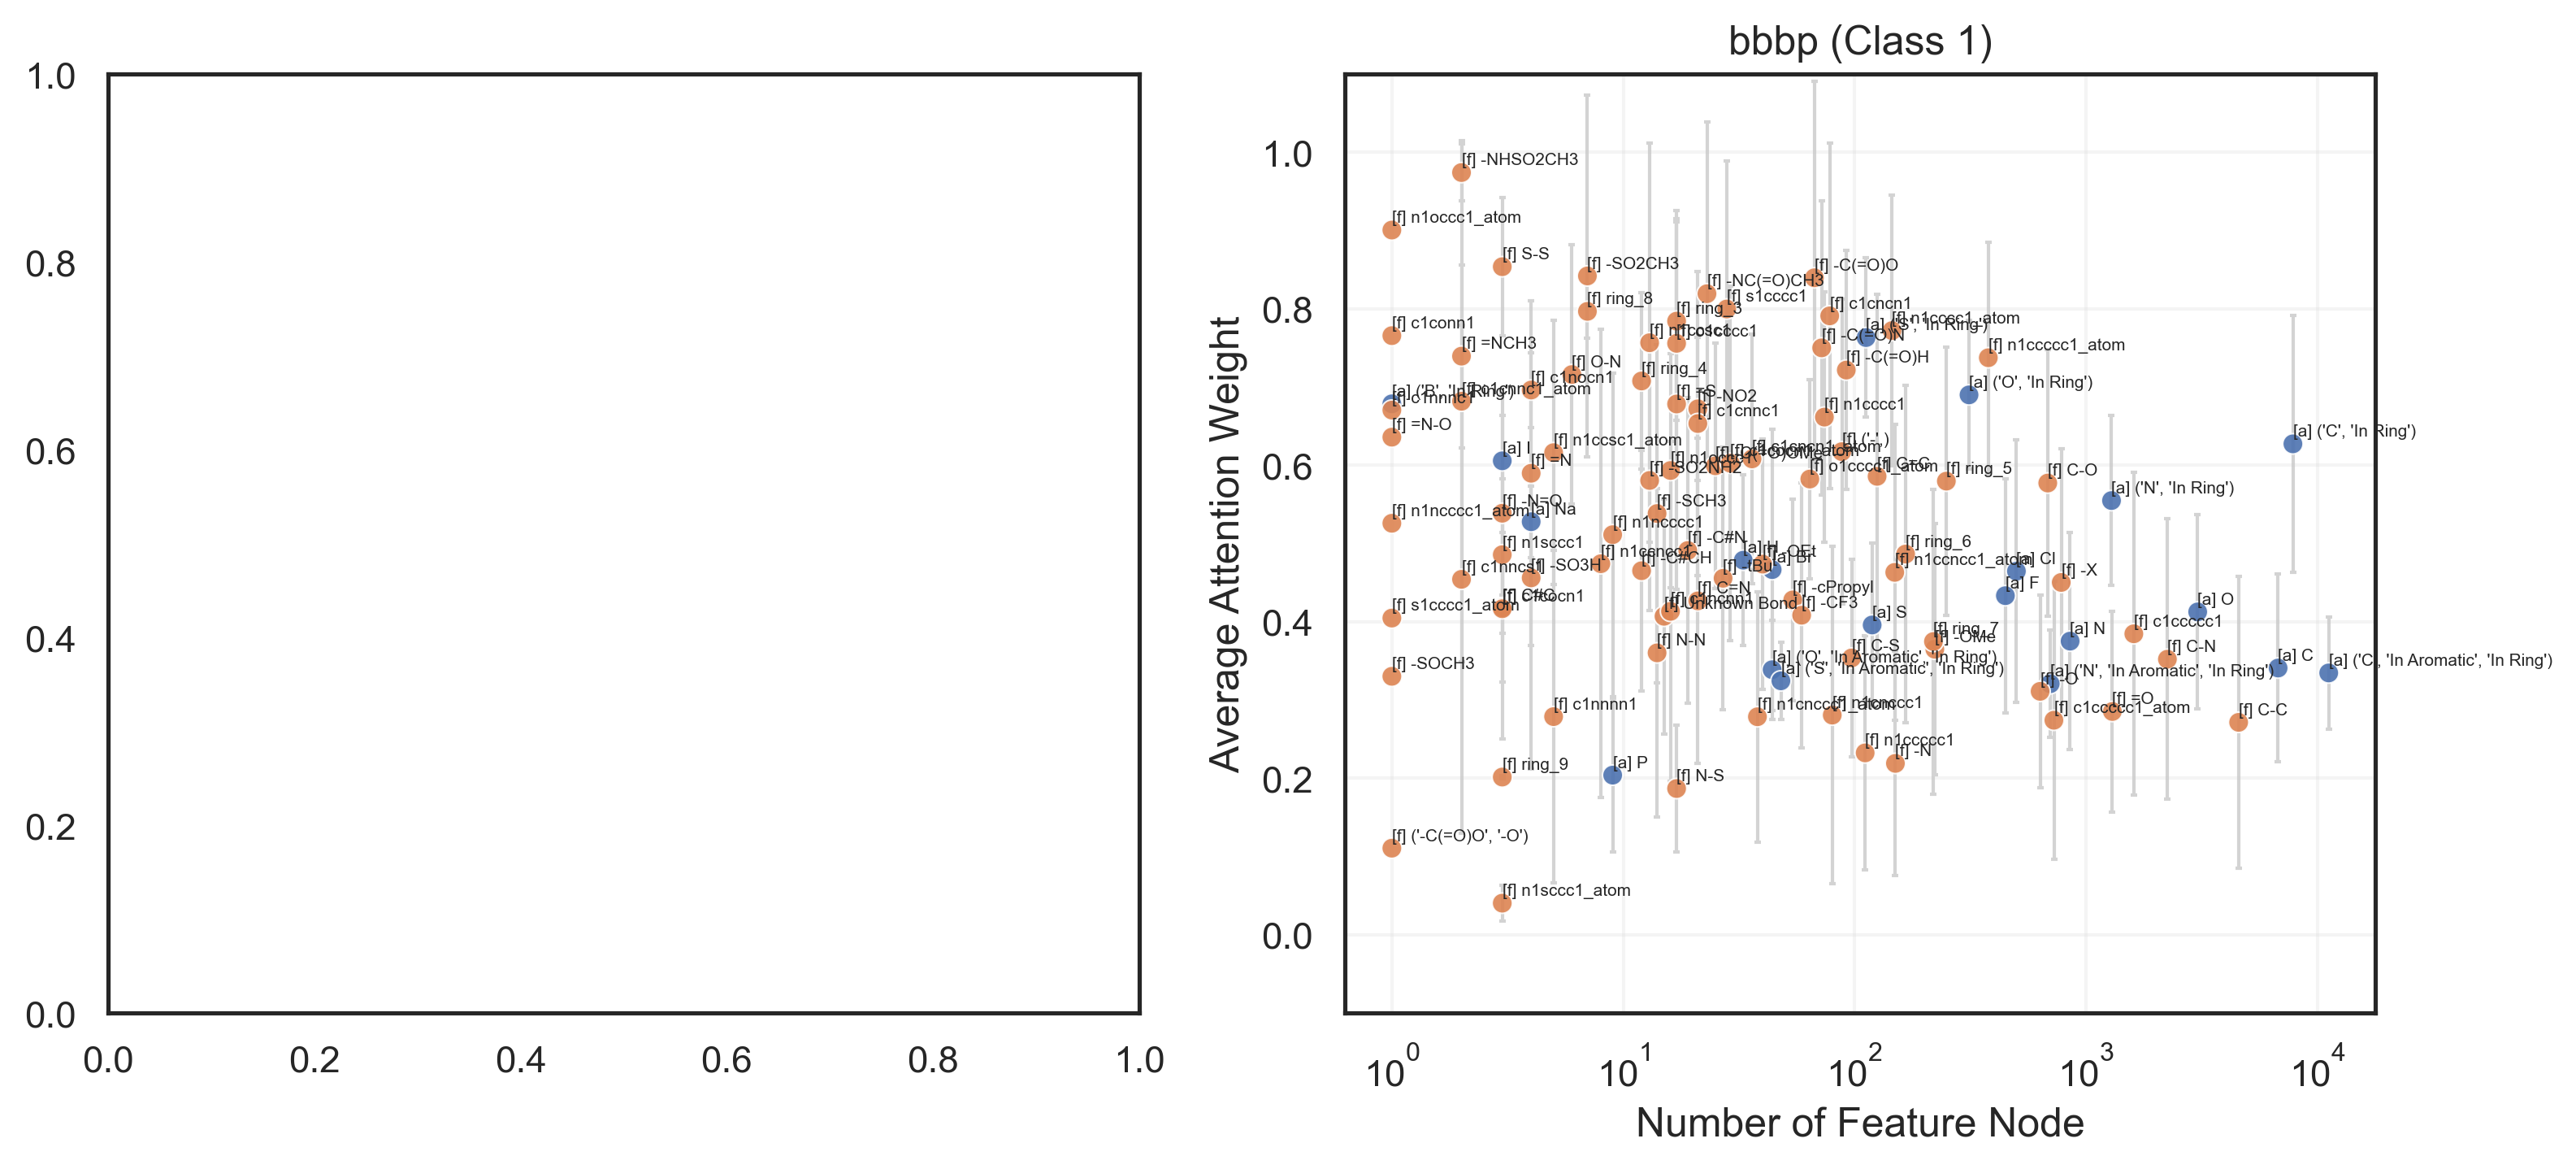

In [31]:
sns.set_theme(style="white", palette=None)
def label_point(x, y, val, ax):
    for xi, yi, vali in zip(x, y, val):
        ax.text(xi, yi+.01, str(vali), fontsize=5)

class_threshold = None
if args.file == 't02_aqsoldb_9982':
    # aqsoldb > -2: 1
    # aqsoldb <= -2: 0
    class_threshold = -2

if args.graphtask == 'classification' or class_threshold is not None:
    pred_ar_df = prediction_consensus_df[prediction_consensus_df['Schema']!='x'].copy()
    if class_threshold is not None:
        pred_ar_df['Prediction_Class'] = pred_ar_df['Prediction']>class_threshold
    else:
        pred_ar_df['Prediction_Class'] = pred_ar_df['Prediction']>=0.5
    # filter by list
    # pred_ar_df = pred_ar_df[pred_ar_df['Node_Feature'].isin(feature_mt_10)]
    # feature node occurance by class
    feature_occ_df_class = dict()
    feature_occ_df_class[0] = countOccurance(pred_ar_df[pred_ar_df['Prediction_Class']==0])
    feature_occ_df_class[1] = countOccurance(pred_ar_df[pred_ar_df['Prediction_Class']==1])

    avg_att_df = pred_ar_df.groupby(['Node_Feature', 'Prediction_Class'], as_index=False).agg({'Weight':['mean','std']})
    avg_att_df.columns = ['Node_Feature', 'Prediction_Class', 'Weight_Mean', 'Weight_Std']
    avg_att_df = avg_att_df.sort_values(by=['Weight_Mean'], ascending=False).reset_index(drop=True)
    avg_att_df['Node_Feature_Type'] = avg_att_df['Node_Feature'].apply(lambda x: x.split(' ')[0])
    display(len(avg_att_df), avg_att_df.head())
    labels = list(avg_att_df['Node_Feature'])
    pred_ar_df = pred_ar_df.sort_values(by='Node_Feature', key=lambda x: x.map({v: i for i, v in enumerate(avg_att_df['Node_Feature'])}))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for p in [1]:
        df_dataframe = avg_att_df[avg_att_df['Prediction_Class'] == p]
        df_dataframe = df_dataframe.sort_values(by=['Node_Feature_Type']).reset_index(drop=True)
        df_dataframe = df_dataframe.merge(feature_occ_df_class[p], how='left', on='Node_Feature')

        # display(len(df_dataframe), df_dataframe.head())
        
        ax = sns.scatterplot(data=df_dataframe, 
                             x=df_dataframe['Node_Feature_nodes_series'], 
                             y=df_dataframe['Weight_Mean'], 
                             hue=df_dataframe['Node_Feature_Type'], ax=axes[p], alpha=0.9)
        ax.errorbar(df_dataframe['Node_Feature_nodes_series'], 
                     df_dataframe['Weight_Mean'], 
                     yerr=df_dataframe['Weight_Std'], 
                     linestyle="None", ecolor='lightgray', elinewidth=1, capsize=1, zorder=-1)
        label_point(df_dataframe['Node_Feature_nodes_series'], 
                    df_dataframe['Weight_Mean'], 
                    df_dataframe['Node_Feature'], ax)
        ax.yaxis.grid(True)
        ax.xaxis.grid(True)
        ax.set_ylim([-0.1, 1.1])
        ax.grid(alpha=0.2)
        ax.set(title=file+' (Class '+str(p)+')')
        ax.set(xscale="log")
        ax.set(ylabel='Average Attention Weight')
        ax.set(xlabel='Number of Feature Node')
        ax.legend_.remove()
    plt.show()

In [32]:
if args.graphtask == 'classification':
    pred_ar_df = prediction_consensus_df[prediction_consensus_df['Schema']!='x'].copy()
    pred_ar_df['Prediction_Class'] = pred_ar_df['Prediction']>=0.5
    # filter by list
    # pred_ar_df = pred_ar_df[pred_ar_df['Node_Feature'].isin(feature_mt_10)]
    # feature node occurance by class
    feature_occ_df_class = dict()
    feature_occ_df_class[0] = countOccurance(pred_ar_df[pred_ar_df['Prediction_Class']==0])
    feature_occ_df_class[1] = countOccurance(pred_ar_df[pred_ar_df['Prediction_Class']==1])

    avg_att_df = pred_ar_df.groupby(['Node_Feature', 'Prediction_Class'], as_index=False).agg({'Weight':['mean','std']})
    avg_att_df.columns = ['Node_Feature', 'Prediction_Class', 'Weight_Mean', 'Weight_Std']
    avg_att_df = avg_att_df.sort_values(by=['Weight_Mean'], ascending=False).reset_index(drop=True)
    avg_att_df['Node_Feature_Type'] = avg_att_df['Node_Feature'].apply(lambda x: x.split(' ')[0])
    display(len(avg_att_df), avg_att_df.head())
    labels = list(avg_att_df['Node_Feature'])
    pred_ar_df = pred_ar_df.sort_values(by='Node_Feature', key=lambda x: x.map({v: i for i, v in enumerate(avg_att_df['Node_Feature'])}))

    diff_list = list()
    diff_df = avg_att_df[['Node_Feature']].reset_index(drop=True).drop_duplicates()
    avg_att_df_class0 = avg_att_df[avg_att_df['Prediction_Class']==0].reset_index(drop=True)
    avg_att_df_class1 = avg_att_df[avg_att_df['Prediction_Class']==1].reset_index(drop=True)
    avg_att_df_class0 = avg_att_df_class0.merge(feature_occ_df_class[0], how='left', on='Node_Feature')
    avg_att_df_class1 = avg_att_df_class1.merge(feature_occ_df_class[1], how='left', on='Node_Feature')
    diff_df = diff_df.merge(avg_att_df_class0, how='left', on='Node_Feature')
    diff_df = diff_df.merge(avg_att_df_class1, how='left', on='Node_Feature', suffixes=('_class0', '_class1'))
    diff_df = diff_df[['Node_Feature', 'Node_Feature_nodes_series_class0', 'Weight_Mean_class0', 'Node_Feature_nodes_series_class1', 'Weight_Mean_class1']]
    diff_df['Weight_Mean_Diff'] = np.where((diff_df['Weight_Mean_class1'] - diff_df['Weight_Mean_class0']).isna(), 
                                           np.where(diff_df['Weight_Mean_class1'].isna(),  -diff_df['Weight_Mean_class0'], diff_df['Weight_Mean_class1']), 
                                           diff_df['Weight_Mean_class1'] - diff_df['Weight_Mean_class0'])
        
    diff_df = diff_df.sort_values(by=['Weight_Mean_Diff'], ascending=False).reset_index(drop=True)
    diff_df = diff_df[diff_df['Node_Feature_nodes_series_class0'] > 10]
    diff_df = diff_df[diff_df['Node_Feature_nodes_series_class1'] > 10]
    display(len(diff_df), diff_df.head(20))

202

Node_Feature  Prediction_Class  Weight_Mean  Weight_Std  \
0     [f] -NHSO2CH3              True     0.974238    0.036433   
1       [f] -C(=O)O             False     0.957054    0.095760   
2  [f] n1occc1_atom              True     0.900750         NaN   
3       [f] c1cncn1             False     0.899491    0.130097   
4           [f] S-S             False     0.871182         NaN   

  Node_Feature_Type  
0               [f]  
1               [f]  
2               [f]  
3               [f]  
4               [f]

45

Node_Feature  Node_Feature_nodes_series_class0  \
13           [f] n1ccsc1                              34.0   
18           [f] -C(=O)N                              21.0   
19     [f] n1ccncc1_atom                              39.0   
22                [f] -X                             117.0   
25            [f] ('-',)                              52.0   
26           [f] -C(=O)H                              49.0   
28  [a] ('S', 'In Ring')                             139.0   
31          [f] c1ccccc1                             413.0   
32            [f] ring_4                             139.0   
37               [f] C-S                             106.0   
39               [f] C=N                              47.0   
40            [f] ring_6                             222.0   
42               [f] C-N                             972.0   
43          [f] n1cnccc1                              18.0   
44           [f] o1cccc1                              13.0   
46     [f] n1ccccc1_atom                              24.0   
47  [a] ('C', 'In Ring')                            3574.0   
49     [f] c1ccccc1_atom                             219.0   
50               [f] C=C                              58.0   
53      [f] o1cccc1_atom                              25.0   

    Weight_Mean_class0  Node_Feature_nodes_series_class1  Weight_Mean_class1  \
13            0.394678                              13.0            0.756761   
18            0.482746                              72.0            0.750198   
19            0.195926                             149.0            0.463245   
22            0.215987                             781.0            0.450381   
25            0.391973                              88.0            0.617543   
26            0.503818                              92.0            0.721793   
28            0.557427                             112.0            0.763323   
31            0.186633                            1608.0            0.384753   
32            0.513937                              12.0            0.707864   
37            0.213063                              97.0            0.353881   
39            0.289268                              21.0            0.426806   
40            0.351228                             166.0            0.486635   
42            0.221668                            2246.0            0.352261   
43            0.150475                              80.0            0.280836   
44            0.629558                              17.0            0.755947   
46            0.622245                             378.0            0.737560   
47            0.512236                            7830.0            0.627510   
49            0.167018                             726.0            0.274264   
50            0.486460                             125.0            0.585972   
53            0.491946                              64.0            0.582526   

    Weight_Mean_Diff  
13          0.362083  
18          0.267452  
19          0.267318  
22          0.234394  
25          0.225570  
26          0.217975  
28          0.205896  
31          0.198120  
32          0.193927  
37          0.140818  
39          0.137537  
40          0.135407  
42          0.130594  
43          0.130361  
44          0.126389  
46          0.115315  
47          0.115274  
49          0.107246  
50          0.099512  
53          0.090581

## Average Weight vs Prediction

78

Node_Feature  Weight_Mean  Weight_Std  Prediction_Mean  Prediction_Std  \
0       [f] -C(=O)O     0.927280    0.158887         0.273991        0.366337   
1       [f] c1cncn1     0.816579    0.208060         0.740206        0.302331   
2    [f] -NC(=O)CH3     0.791636    0.223172         0.776302        0.257698   
3  [f] n1cccc1_atom     0.777515    0.168190         0.759038        0.345583   
4       [f] s1cccc1     0.761983    0.204723         0.800886        0.355421   

  Node_Feature_Type  
0               [f]  
1               [f]  
2               [f]  
3               [f]  
4               [f]

78

Node_Feature  Weight_Mean  Weight_Std  Prediction_Mean  \
0              [a] C     0.349176    0.114980         0.676522   
1             [a] Br     0.463263    0.170694         0.874733   
2             [a] Cl     0.467553    0.157136         0.819958   
3              [a] H     0.487777    0.102905         0.795085   
4              [a] S     0.392581    0.090449         0.563330   
..               ...          ...         ...              ...   
73         [f] -SCH3     0.569242    0.215978         0.724451   
74        [f] ring_5     0.570367    0.170840         0.842228   
75  [f] c1cncn1_atom     0.580739    0.189097         0.752273   
76        [f] ring_4     0.529348    0.171011         0.100500   
77       [f] ring_>9     0.042277    0.040903         0.015392   

    Prediction_Std Node_Feature_Type  Node_Feature_nodes_series  \
0         0.390428               [a]                       9663   
1         0.220147               [a]                         49   
2         0.283951               [a]                        587   
3         0.314291               [a]                         40   
4         0.408485               [a]                        206   
..             ...               ...                        ...   
73        0.380412               [f]                         19   
74        0.255099               [f]                        285   
75        0.328808               [f]                         45   
76        0.249874               [f]                        151   
77        0.029702               [f]                         55   

    Node_Feature_smiles_series  
0                         1866  
1                           44  
2                          418  
3                           37  
4                          185  
..                         ...  
73                          19  
74                         240  
75                          44  
76                         147  
77                          37  

[78 rows x 8 columns]

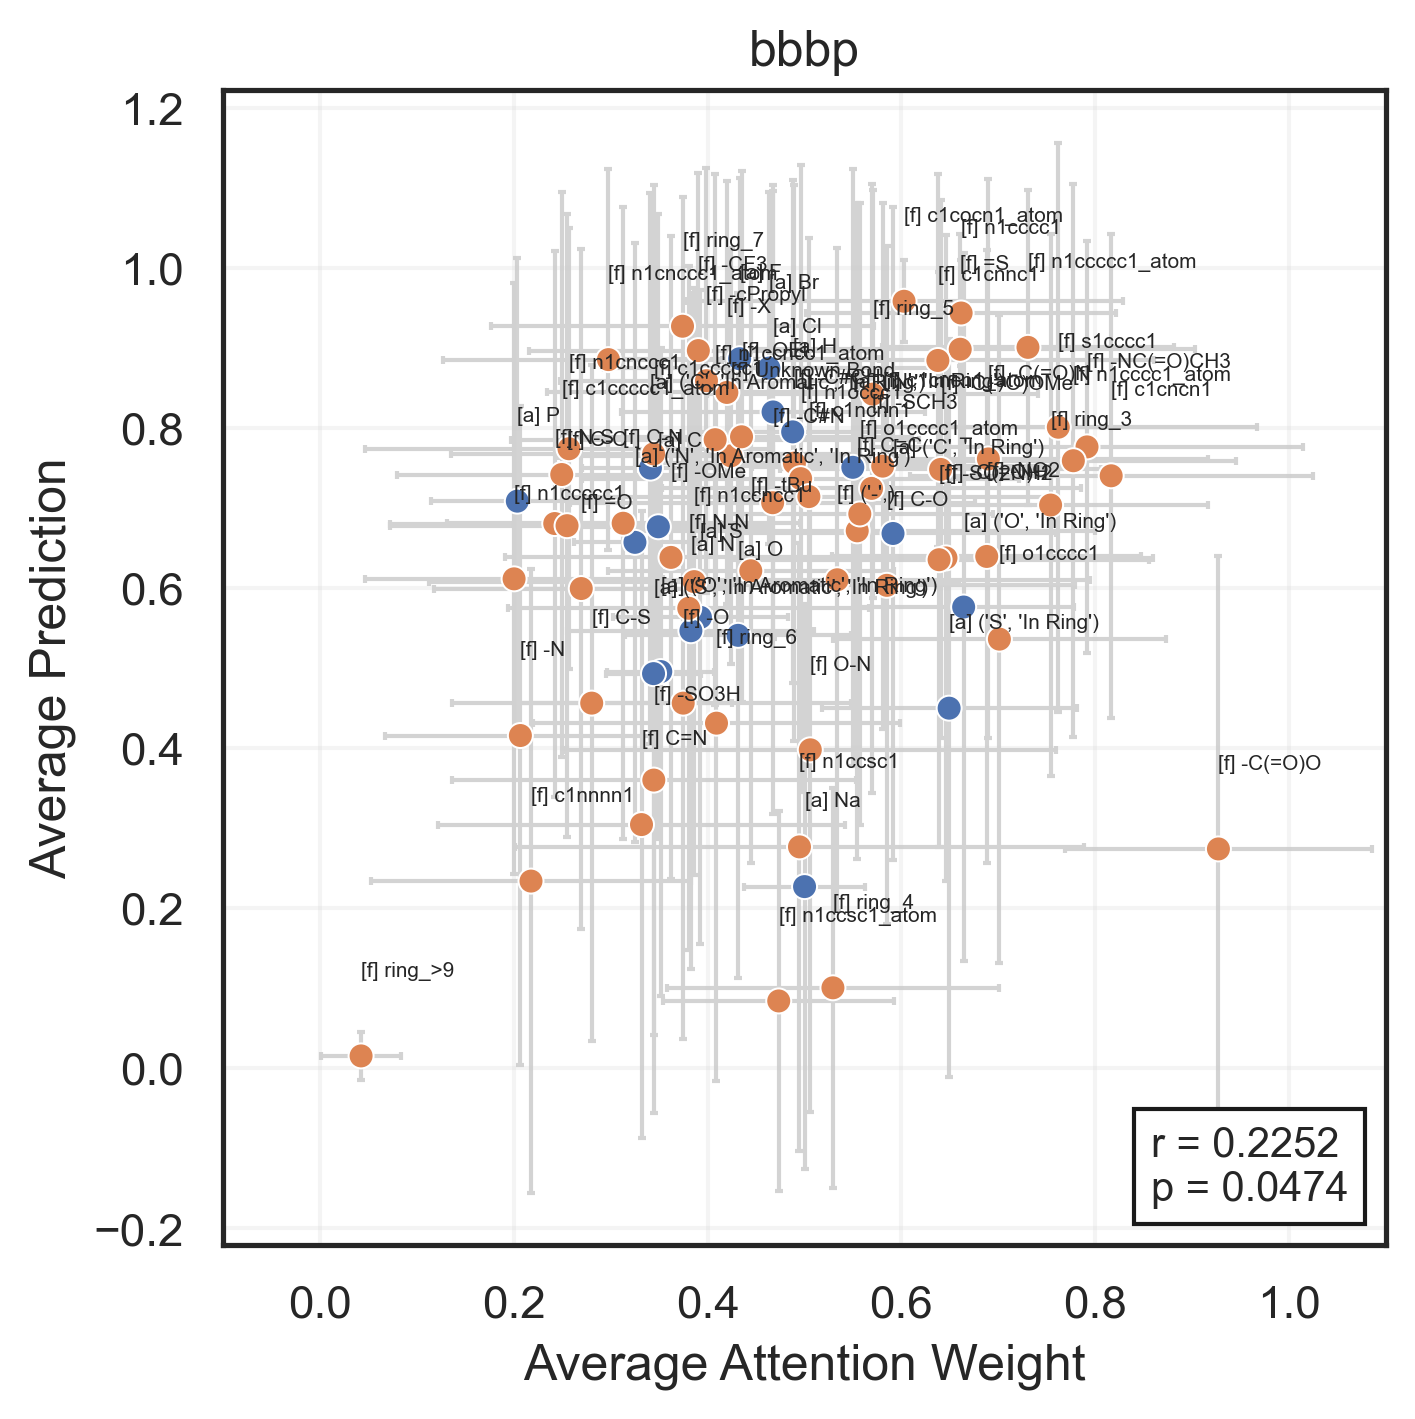

In [33]:
from matplotlib.offsetbox import AnchoredText
sns.set_theme(style="white", palette=None)

def label_point(x, y, val, ax, y_offset=0.01):
    for xi, yi, vali in zip(x, y, val):
        ax.text(xi, yi+y_offset, str(vali), fontsize=5)

if args.graphtask == 'regression' or args.graphtask == 'classification':
    pred_ar_df = prediction_consensus_df[prediction_consensus_df['Schema']!='x'].copy()
    # filter by list
    pred_ar_df = pred_ar_df[pred_ar_df['Node_Feature'].isin(feature_mt_10)]

    avg_att_df = pred_ar_df.groupby(['Node_Feature'], as_index=False).agg({'Weight':['mean','std'], 'Prediction':['mean','std']})
    avg_att_df.columns = ['Node_Feature', 'Weight_Mean', 'Weight_Std', 'Prediction_Mean', 'Prediction_Std']
    avg_att_df = avg_att_df.sort_values(by=['Weight_Mean'], ascending=False).reset_index(drop=True)
    avg_att_df['Node_Feature_Type'] = avg_att_df['Node_Feature'].apply(lambda x: x.split(' ')[0])
    display(len(avg_att_df), avg_att_df.head())
    labels = list(avg_att_df['Node_Feature'])
    pred_ar_df = pred_ar_df.sort_values(by='Node_Feature', key=lambda x: x.map({v: i for i, v in enumerate(avg_att_df['Node_Feature'])}))

    fig, axes = plt.subplots(1, 1, figsize=(5, 5))

    df_dataframe = avg_att_df.copy()
    df_dataframe = df_dataframe.sort_values(by=['Node_Feature_Type']).reset_index(drop=True)
    df_dataframe = df_dataframe.merge(feature_occ_df, how='left', on='Node_Feature')

    display(len(df_dataframe), df_dataframe)
    
    ax = sns.scatterplot(data=df_dataframe, 
                            x=df_dataframe['Weight_Mean'], 
                            y=df_dataframe['Prediction_Mean'], 
                            hue=df_dataframe['Node_Feature_Type'])
    ax.errorbar(df_dataframe['Weight_Mean'], 
                    df_dataframe['Prediction_Mean'], 
                    xerr=df_dataframe['Weight_Std'], 
                    yerr=df_dataframe['Prediction_Std'], 
                    linestyle="None", ecolor='lightgray', elinewidth=1, capsize=1, zorder=-1)
    label_point(df_dataframe['Weight_Mean'], 
                df_dataframe['Prediction_Mean'], 
                df_dataframe['Node_Feature'], ax, y_offset=0.1)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_xlim([-0.1, 1.1])
    ax.grid(alpha=0.2)
    ax.set(title=file)
    ax.set(ylabel='Average Prediction')
    ax.set(xlabel='Average Attention Weight')
    ax.legend_.remove()
    r, p = sp.stats.pearsonr(df_dataframe['Prediction_Mean'], df_dataframe['Weight_Mean'])
    anchored_text = AnchoredText("r = {:.4f}".format(r)+"\n"+"p = {:.4f}".format(p), loc=4, prop=dict(size='small'))
    ax.add_artist(anchored_text)
    plt.show()

## Attention Weights vs Prediction - Single Node Features

Node_Feature    Weight  PearsonR        Pvalue
13  [a] ('S', 'In Ring')  0.649301  0.794388  7.754079e-56
32           [f] n1occc1  0.496033  0.788516  1.304814e-05
29               [f] O-N  0.505986  0.744340  1.459509e-03
33           [f] n1ccsc1  0.494828  0.624645  2.696925e-06
51          [f] n1ccncc1  0.386117  0.567426  5.432403e-02

Node_Feature    Weight  PearsonR         Pvalue
13                 [a] ('S', 'In Ring')  0.649301  0.794388   7.754079e-56
32                          [f] n1occc1  0.496033  0.788516   1.304814e-05
29                              [f] O-N  0.505986  0.744340   1.459509e-03
33                          [f] n1ccsc1  0.494828  0.624645   2.696925e-06
48                         [f] -cPropyl  0.398827  0.561421   3.061925e-06
67                              [f] C-S  0.280350  0.549021   2.232992e-17
8                           [f] -C(=O)N  0.689806  0.525824   6.217269e-08
18                     [f] c1cocn1_atom  0.602802  0.501625   5.565114e-03
41                             [f] -OEt  0.435005  0.493016   3.706334e-04
47                    [f] n1ccncc1_atom  0.407790  0.480946   2.831851e-12
27                           [f] ('-',)  0.533760  0.455150   1.605634e-08
14                          [f] -C(=O)H  0.646043  0.450701   2.045412e-08
45                               [f] -X  0.419842  0.419474   1.399047e-39
7                           [f] o1cccc1  0.701178  0.404097   2.678057e-02
4                           [f] s1cccc1  0.761983  0.395387   2.064254e-02
60                         [f] c1ccccc1  0.344266  0.384680   2.836041e-72
50                             [f] -CF3  0.390432  0.377485   2.105090e-03
46                           [f] ring_6  0.409160  0.371392   3.902063e-14
28                           [f] ring_4  0.529348  0.352531   9.023134e-06
65                              [f] C-N  0.312815  0.350921   6.755168e-94
63                              [f] C=N  0.331743  0.343758   4.102450e-03
19                 [a] ('C', 'In Ring')  0.591383  0.341213  7.417667e-309
36                     [f] n1ccsc1_atom  0.473402  0.326369   5.826792e-03
21                     [f] c1cncn1_atom  0.580739  0.317225   3.372779e-02
24                     [f] o1cccc1_atom  0.557082  0.316037   2.552277e-03
71                    [f] c1ccccc1_atom  0.249410  0.291778   5.305015e-20
10                 [a] ('O', 'In Ring')  0.664293  0.278090   6.652119e-11
76                         [f] n1ccccc1  0.200214  0.270067   2.362071e-04
6                     [f] n1ccccc1_atom  0.730676  0.245656   6.143203e-07
69                         [f] n1cnccc1  0.256892  0.229153   2.322672e-02
25                              [f] C=C  0.554432  0.197796   7.275450e-03
22                           [f] ring_5  0.570367  0.176310   2.819101e-03
70                              [f] C-C  0.254893  0.132213   9.374322e-27
68                               [f] =O  0.269548  0.131335   1.191872e-09
26                 [a] ('N', 'In Ring')  0.549856  0.095921   8.305300e-05
20                              [f] C-O  0.584973 -0.075975   1.198692e-02
52                                [a] N  0.382716 -0.081277   1.511703e-03
37                               [a] Cl  0.467553 -0.092859   2.445784e-02
64  [a] ('N', 'In Aromatic', 'In Ring')  0.324971 -0.116996   1.525157e-04
58                                [a] C  0.349176 -0.133942   6.338444e-40
43                                [a] O  0.431457 -0.193003   2.106316e-47
62  [a] ('C', 'In Aromatic', 'In Ring')  0.340956 -0.208013  1.804234e-140
1                           [f] c1cncn1  0.816579 -0.292177   2.884565e-03
54                               [f] -O  0.374790 -0.330833   1.890021e-36
0                           [f] -C(=O)O  0.927280 -0.335034   2.406176e-08
57  [a] ('O', 'In Aromatic', 'In Ring')  0.351643 -0.335180   1.412003e-03
66                    [f] n1cnccc1_atom  0.297631 -0.421033   6.120200e-03
61  [a] ('S', 'In Aromatic', 'In Ring')  0.344173 -0.425914   1.683923e-05
15                        [f] -C(=O)OMe  0.640482 -0.519256   2.759286e-03

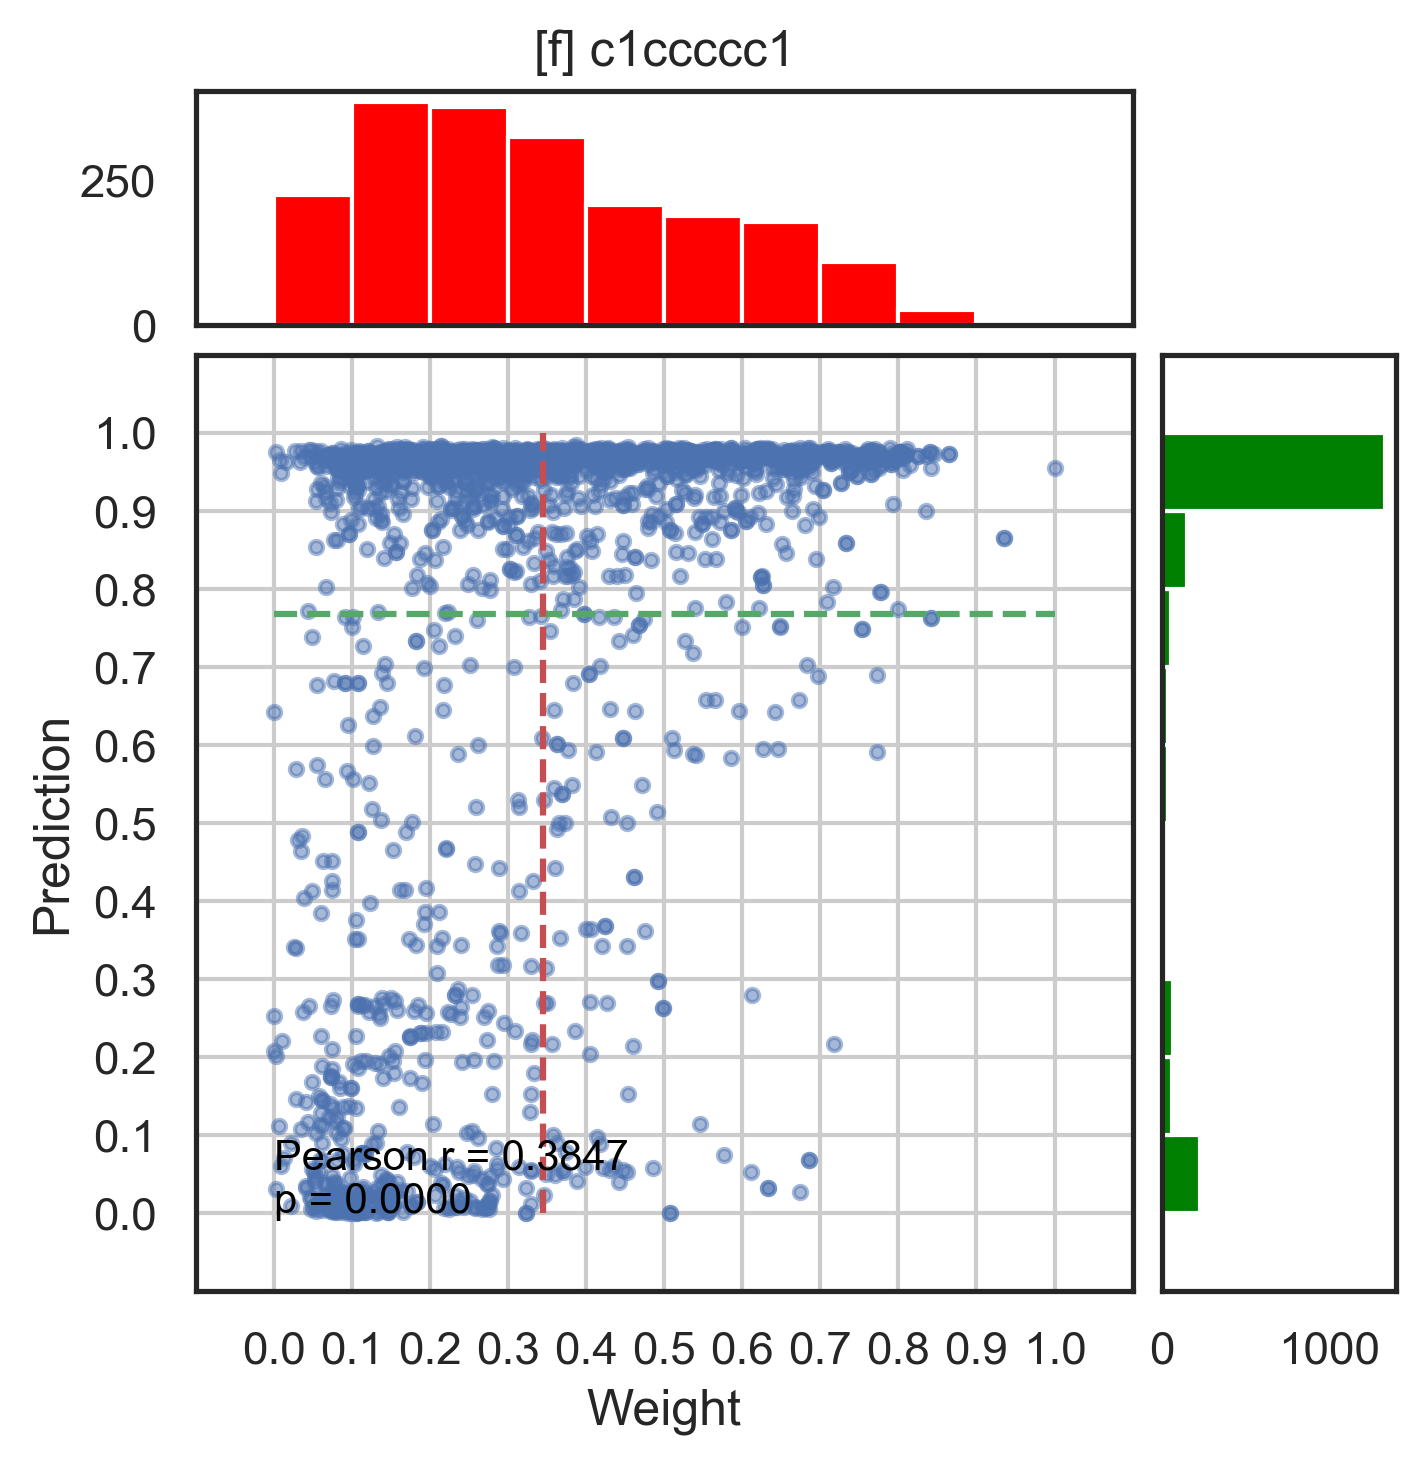

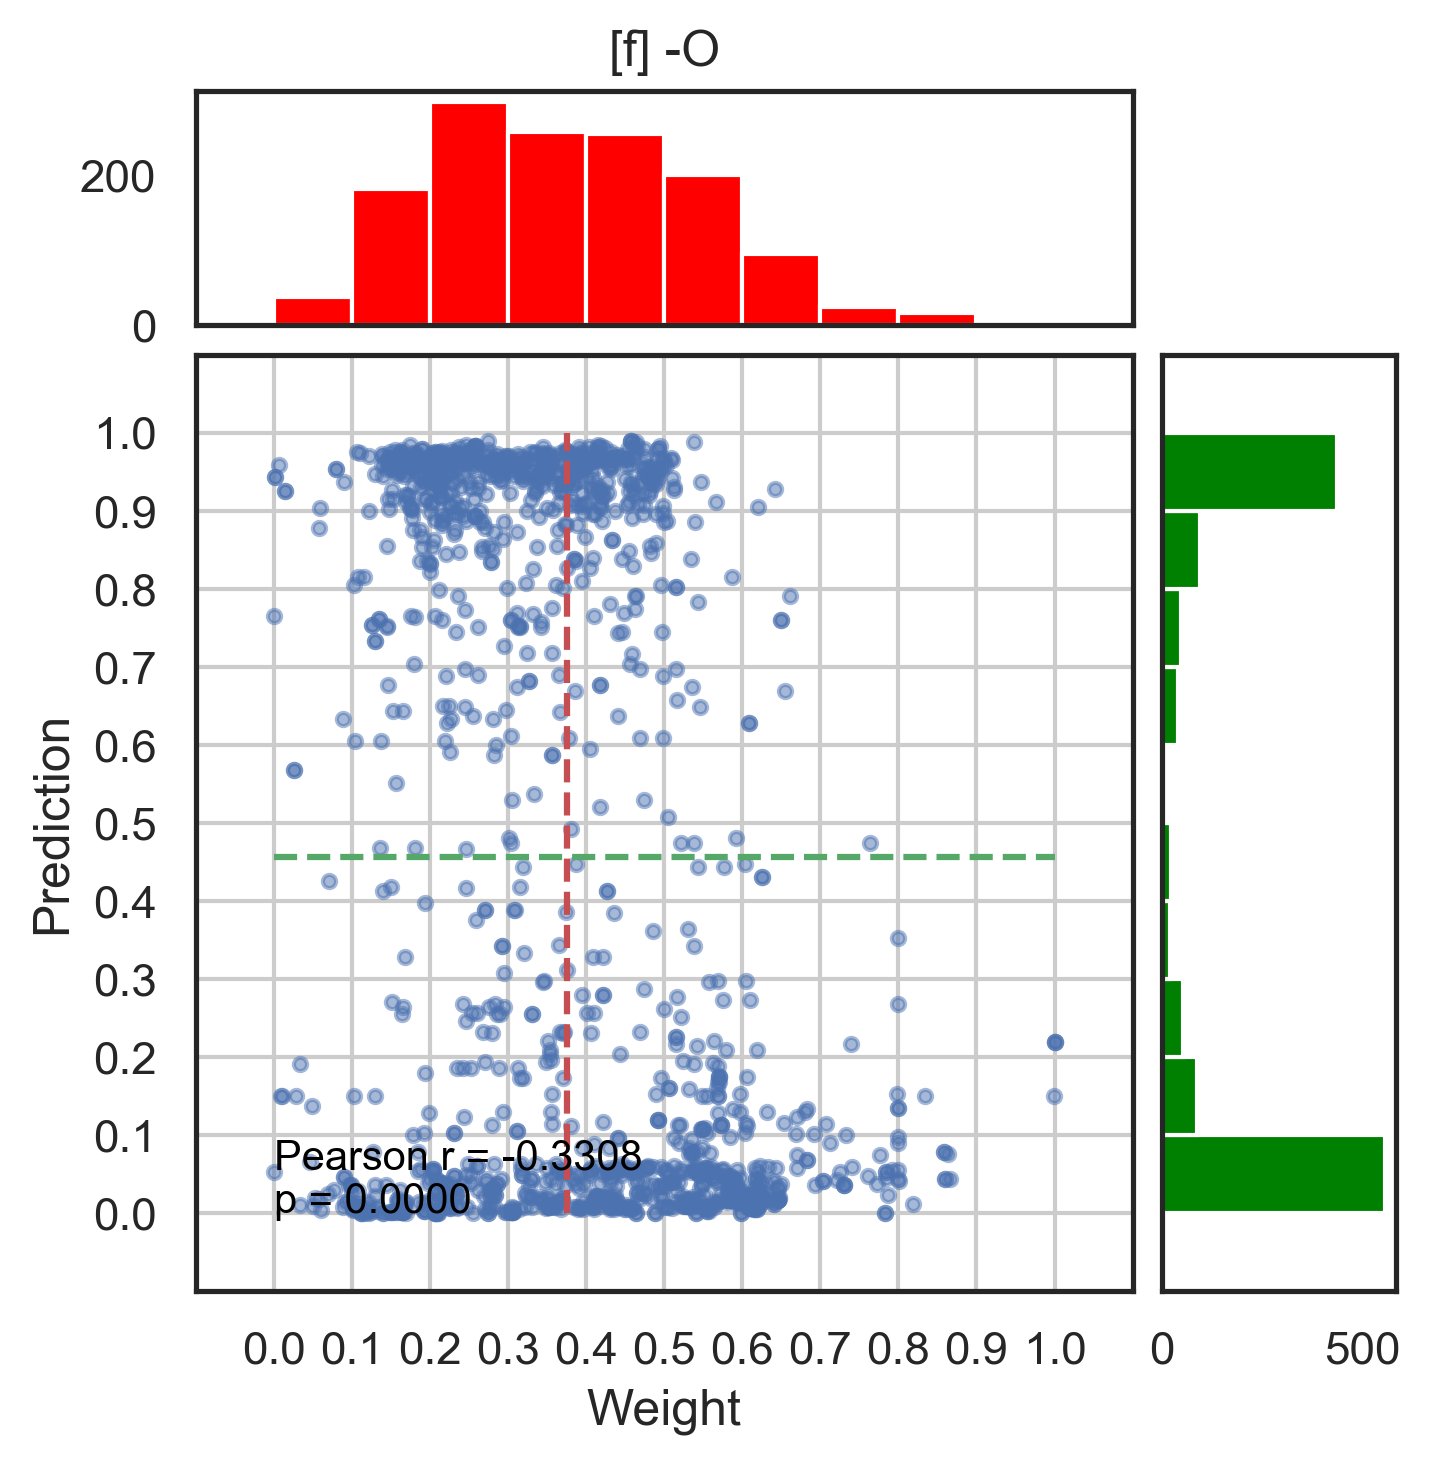

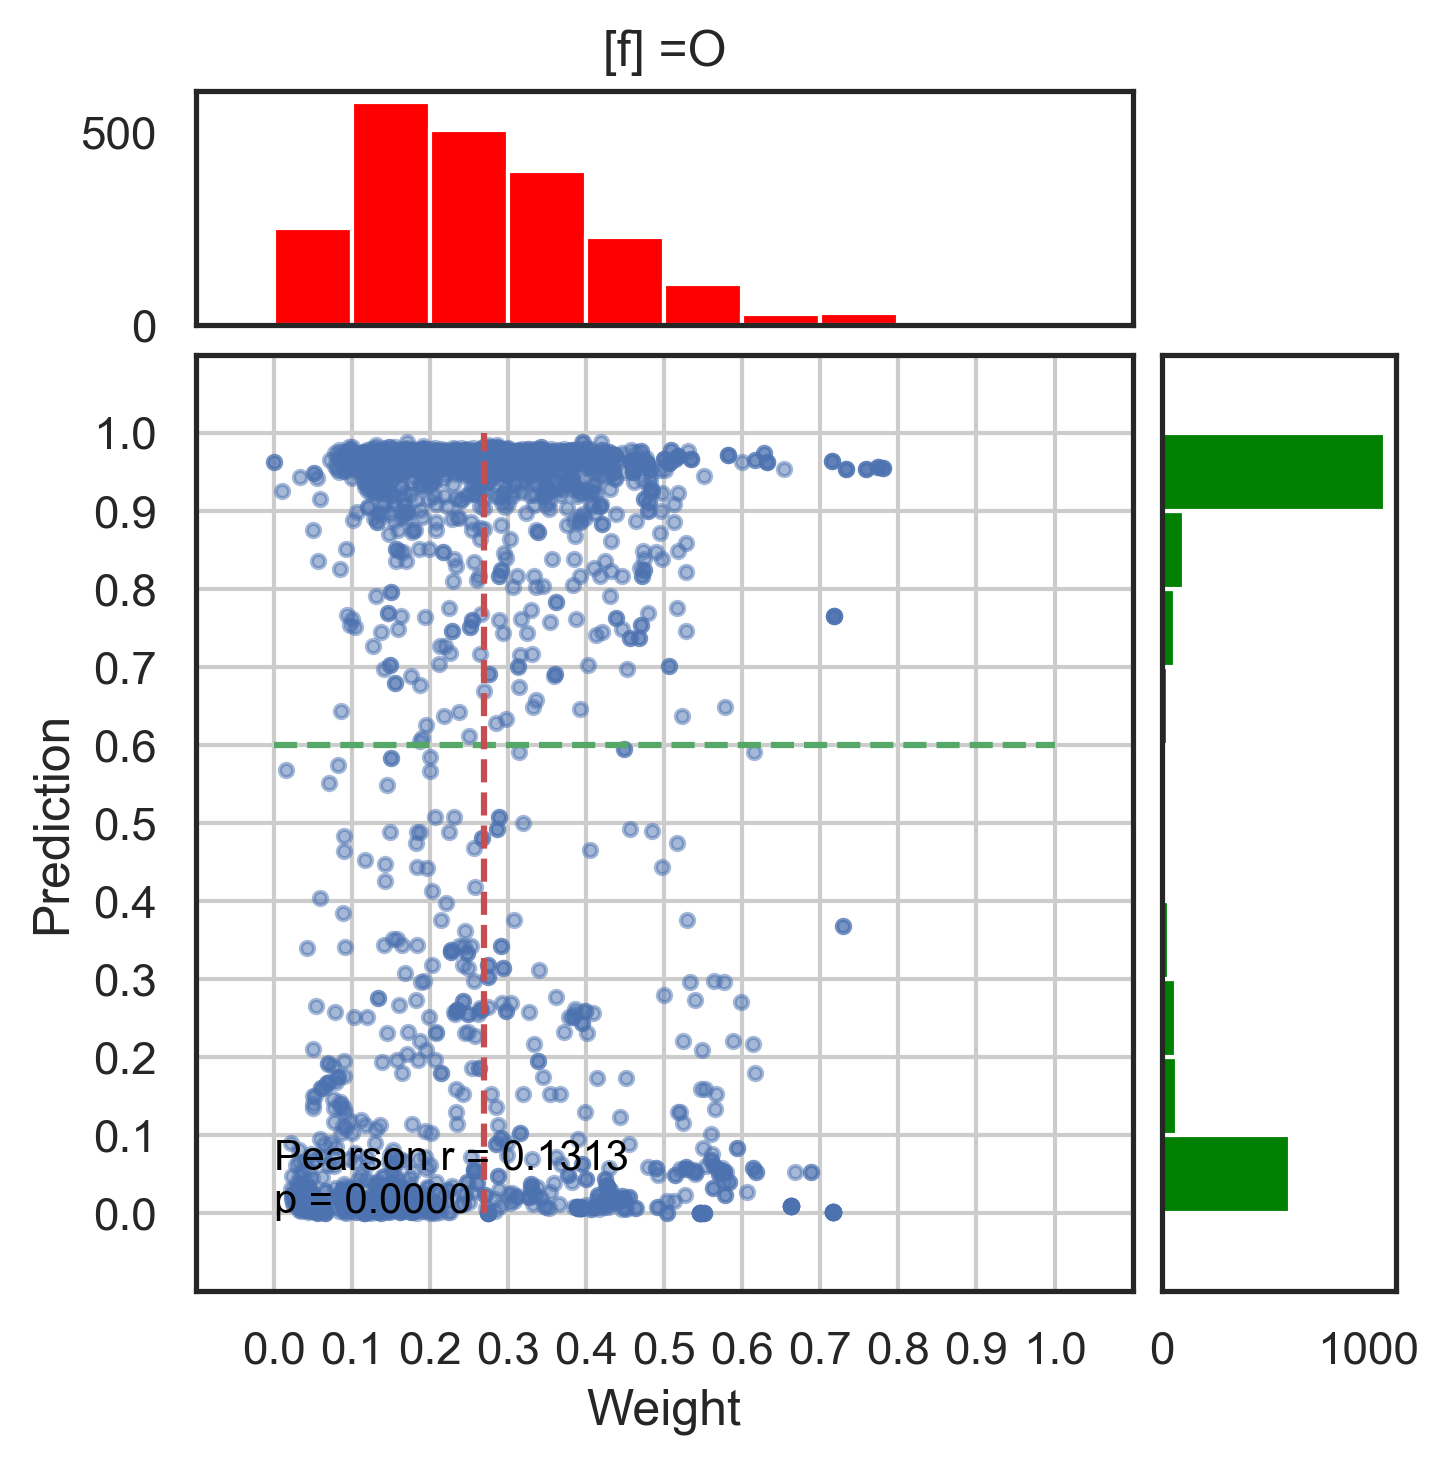

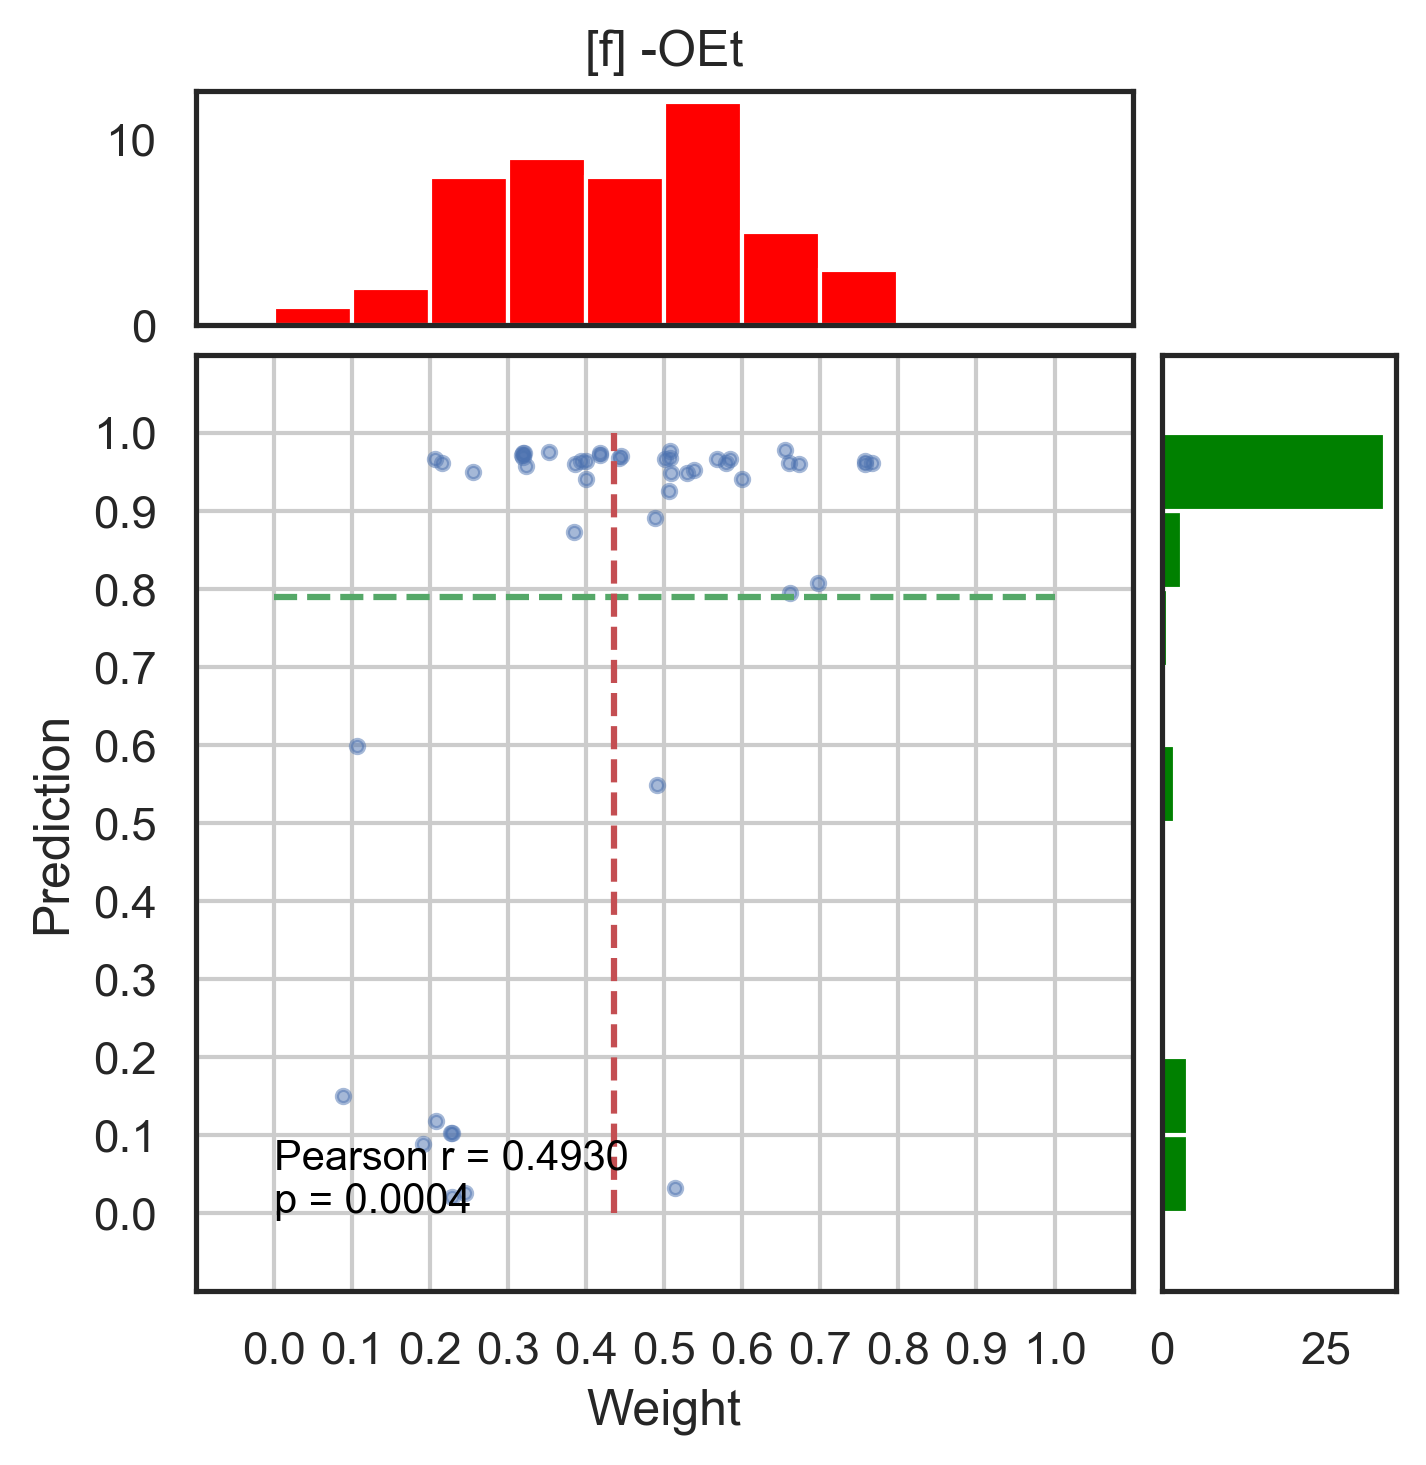

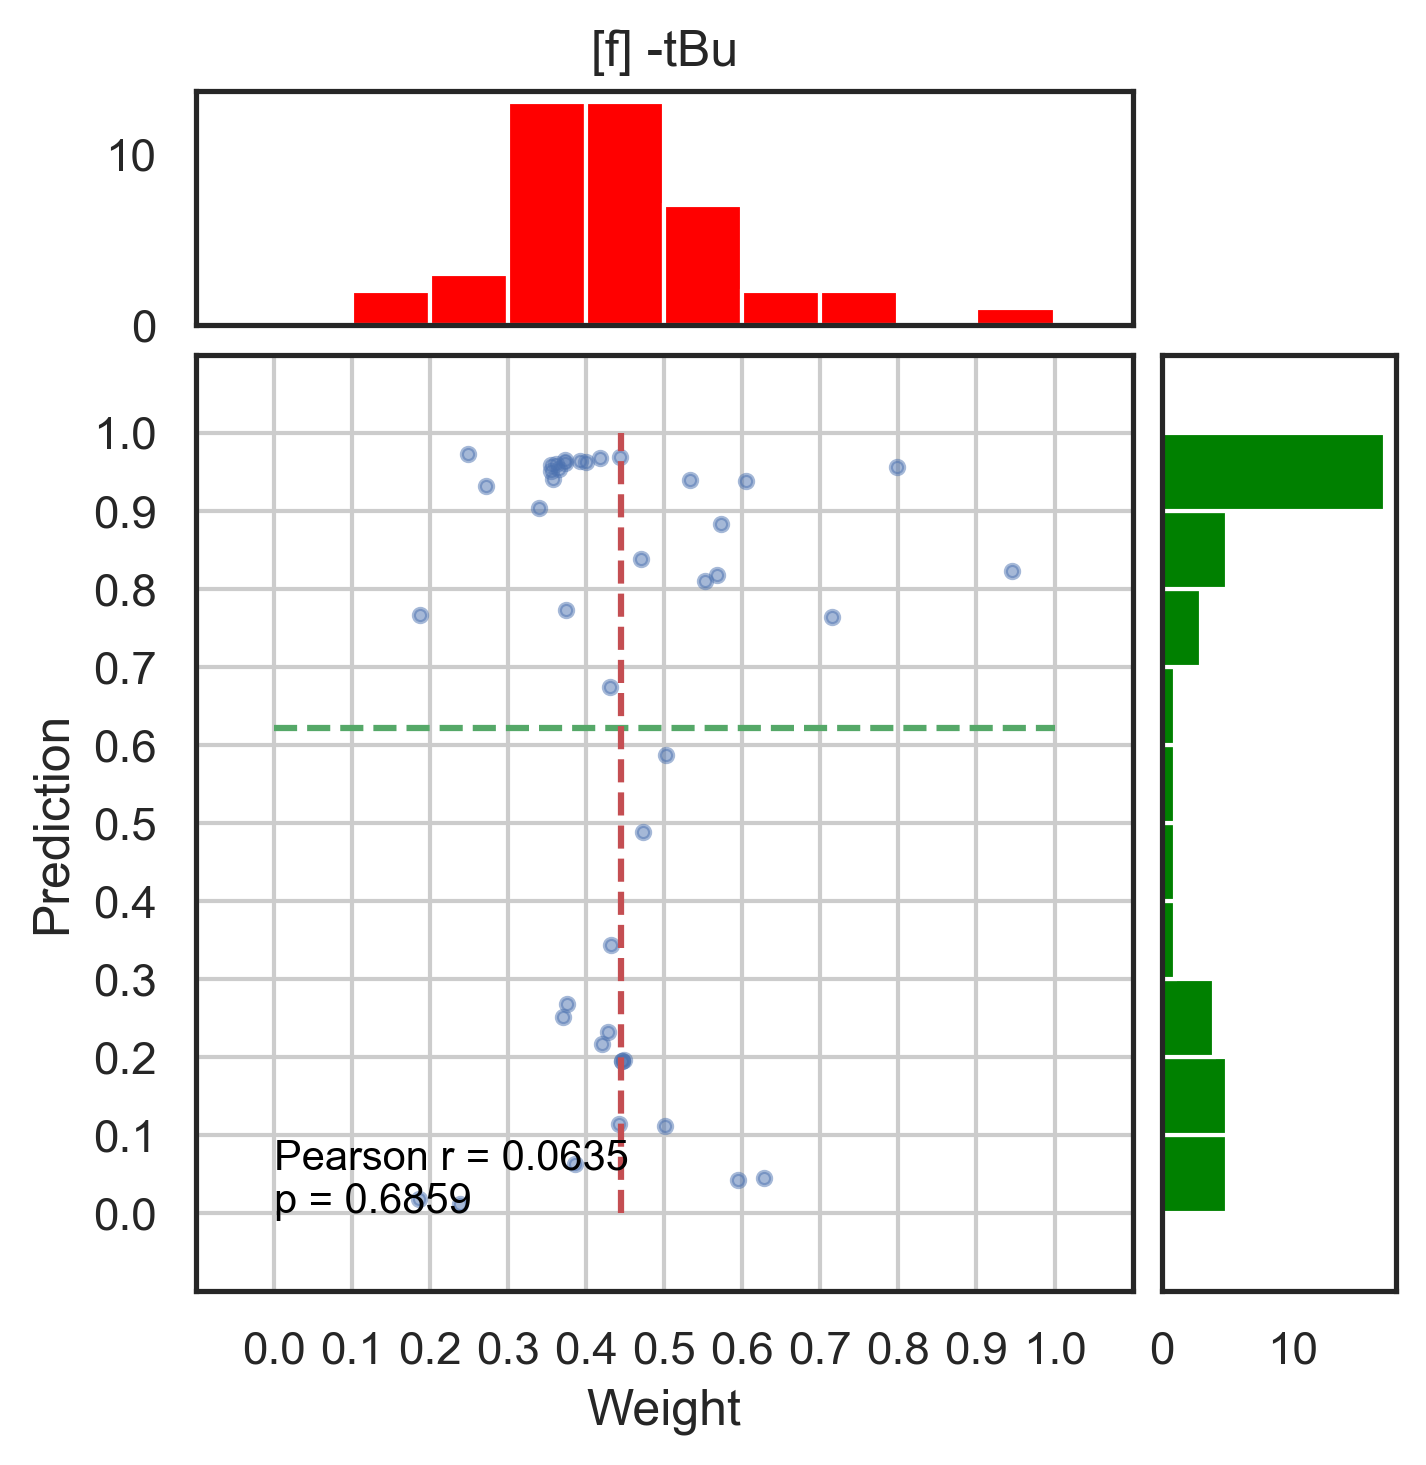

In [34]:
from matplotlib.offsetbox import AnchoredText
sns.set_theme(style="white", palette=None)

if args.graphtask == 'regression' or args.graphtask == 'classification':
    
    pred_ar_df = prediction_consensus_df[prediction_consensus_df['Schema']!='x'].copy()
    # filter by list
    pred_ar_df = pred_ar_df[pred_ar_df['Node_Feature'].isin(feature_mt_10)]

    avg_att_df = pred_ar_df.groupby(['Node_Feature'])['Weight'].mean().reset_index().sort_values(by=['Weight'], ascending=False).reset_index(drop=True)
    labels = list(avg_att_df['Node_Feature'])
    pred_ar_df = pred_ar_df.sort_values(by='Node_Feature', key=lambda x: x.map({v: i for i, v in enumerate(avg_att_df['Node_Feature'])}))
    
    y_min = np.floor(pred_ar_df['Prediction'].min()) if args.graphtask == 'regression' else 0
    y_max = np.ceil(pred_ar_df['Prediction'].max()) if args.graphtask == 'regression' else 1

    r_list = []
    p_list = []
    for l in labels:
        pred_ar_df_l_w = pred_ar_df[pred_ar_df['Node_Feature']==l]['Weight']
        pred_ar_df_l_p = pred_ar_df[pred_ar_df['Node_Feature']==l]['Prediction']
        if len(pred_ar_df_l_w) > 1 and len(pred_ar_df_l_p) > 1:
            r, p = sp.stats.pearsonr(pred_ar_df_l_w, pred_ar_df_l_p) 
        else:
            r, p = np.nan, np.nan
        r_list.append(r)
        p_list.append(p)
    avg_att_df['PearsonR'] = r_list
    avg_att_df['Pvalue'] = p_list
    display(avg_att_df.sort_values(by=['PearsonR'], ascending=False).head())
    display(avg_att_df[avg_att_df['Pvalue'] <= 0.05].sort_values(by=['PearsonR'], ascending=False))


    # for l in labels[12:15]:
    for l in ['[f] c1ccccc1', '[f] -O', '[f] =O', '[f] -OEt', '[f] -tBu']:
    # for l in ['[f] -C(=O)O', '[f] =O', '[f] -CF3', '[f] -NHSO2CH3', '[f] -C(=O)N']:
        # Start with a square Figure.
        fig = plt.figure(figsize=(5, 5))
        # Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
        # the size of the marginal axes and the main axes in both directions.
        # Also adjust the subplot parameters for a square plot.
        gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                            left=0.1, right=0.9, bottom=0.1, top=0.9,
                            wspace=0.05, hspace=0.05)

        # Create the Axes.
        ax = fig.add_subplot(gs[1, 0])
        ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
        ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
        ax_histx.set(title=str(l))

        # scatter hist
        def scatter_hist(x, y, ax, ax_histx, ax_histy, c):
            # no labels
            ax_histx.tick_params(axis="x", labelbottom=False)
            ax_histy.tick_params(axis="y", labelleft=False)

            # the scatter plot:
            if c is not None:
                points = ax.scatter(x, y, alpha=0.5, s=10, c=c, cmap="Greens")
            else:
                points = ax.scatter(x, y, alpha=0.5, s=10)
            # average line
            ax.plot([0, 1], [np.average(y), np.average(y)], 'g--')
            ax.plot([np.average(x), np.average(x)], [y_min, y_max], 'r--')
            # limit
            ax.set_xlim(-0.1, 1.1)
            ax.set_xticks(list(np.arange(0, 1.1, 0.1)))
            if args.graphtask == 'regression':
                ax.set_ylim(y_min, y_max) 
                ax.set_yticks(list(np.arange(y_min,y_max,1)))
            if args.graphtask == 'classification': 
                ax.set_ylim(y_min-0.1, y_max+0.1) 
                ax.set_yticks(list(np.arange(y_min,y_max+0.1,.1)))
            ax.yaxis.grid(True)
            ax.xaxis.grid(True)
            ax.set(ylabel='Prediction')
            ax.set(xlabel='Weight')
            r, p = sp.stats.pearsonr(x, y) 
            # anchored_text = AnchoredText("Pearson r = {:.4f}".format(r)+"\n"+"p = {:.4f}".format(p),
            #                             loc='best', prop=dict(size='small'))
            # ax.add_artist(anchored_text)
            ax.text(x=0, y=0, s="Pearson r = {:.4f}".format(r)+"\n"+"p = {:.4f}".format(p), size='small', color='black')
            

            # now determine nice limits by hand:
            binwidth_x = 0.1
            binwidth_y = 1 if args.graphtask == 'regression' else 0.1
            xmax = np.ceil(np.max(x))
            xmin = np.floor(np.min(x))
            ymax = np.ceil(np.max(y))
            ymin = np.floor(np.min(y))
            lim_x = (int(xmax/binwidth_x) + 1) * binwidth_x
            lim_y = (int(ymax/binwidth_y) + 1) * binwidth_y

            bins_x = np.arange(math.floor(xmin), lim_x + binwidth_x, binwidth_x)
            bins_y = np.arange(math.floor(ymin), lim_y + binwidth_y, binwidth_y)
            ax_histx.hist(x, bins=bins_x, color='red')
            ax_histy.hist(y, bins=bins_y, orientation='horizontal', color='green')

        # Draw the scatter plot and marginals.
        pred_ar_df_l_w = pred_ar_df[pred_ar_df['Node_Feature']==l]['Weight']
        pred_ar_df_l_p = pred_ar_df[pred_ar_df['Node_Feature']==l]['Prediction']
        c = pred_ar_df[pred_ar_df['Node_Feature']==l]['Weight'].values
        scatter_hist(pred_ar_df_l_w, pred_ar_df_l_p, ax, ax_histx, ax_histy, c=None)